# Detecting spouse mentions in sentences

We will walk through an example text classification task to explore how Snorkel works with user-defined LFs. Run every cell in the notebook (unless otherwise noted) before proceeding to the next one!
## Classification Task
<img src="imgs/sentence.jpg" width="700px;">

We want to classify each __candidate__ or pair of people mentioned in a sentence, as being married at some point or not.

In the above example, our candidate represents the possible relation `(Barack Obama, Michelle Obama)`. As readers, we know this mention is true due to external knowledge and the keyword of `wedding` occuring later in the sentence.
We begin with some basic setup and data downloading.


In [1]:
%matplotlib inline

import os
import pickle
import tensorflow as tf
import numpy as np

if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("spouse")

from utils import load_data

((dev_df, dev_labels), train_df, (test_df, test_labels)) = load_data()

**Input Data:** `dev_df` is a Pandas DataFrame object, where each row represents a particular __candidate__. The DataFrames contain the fields `sentence`, which refers to the sentence the candidate is in, `tokens`, the tokenized form of the sentence, `person1_word_idx` and `person2_word_idx`, which represent `[start, end]` indices in the tokens at which the first and second person's name appear, respectively.

We also have certain **preprocessed fields**, that we discuss a few cells below. We have other tutorials focused on generating such datasets (e.g., from richy-formatted data), but assume we have access to a Pandas DataFrame for the purpose of this specific tutorial!

In [2]:
dev_df.head()

,person1_word_idx,person2_word_idx,sentence,tokens,person1_right_tokens,person2_right_tokens,between_tokens
0,"(1, 1)","(22, 24)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[are, half, -, sisters]","[., ]","[are, half, -, sisters, to, Kathy, Hilton, ,, ..."
1,"(1, 1)","(7, 8)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[are, half, -, sisters]","[,, the, mother, of]","[are, half, -, sisters, to]"
2,"(7, 8)","(22, 24)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[,, the, mother, of]","[., ]","[,, the, mother, of, socialite, Paris, Hilton,..."
3,"(6, 6)","(20, 21)","Prior to both his guests, Colbert's monologue ...","[Prior, to, both, his, guests, ,, Colbert, s, ...","[s, monologue, -, parts]","[and, his, oft, -]","[s, monologue, -, parts, of, which, he, did, s..."
4,"(2, 2)","(4, 5)",People reported Williams and Ven Veen tied the...,"[People, reported, Williams, and, Ven, Veen, t...","[and, Ven, Veen, tied]","[tied, the, knot, Saturday]",[and]


You'll interact with these candidates while writing labeling functions in Snorkel. We look at a candidate in the development set:

In [3]:
from preprocessors import get_person_text

candidate = dev_df.loc[2]
person_names = get_person_text(candidate).person_names

print("Sentence: ", candidate["sentence"])
print("Person 1: ", person_names[0])
print("Person 2: ", person_names[1])

Sentence:  The Richards are half-sisters to Kathy Hilton, the mother of socialite Paris Hilton and spouse of luxury hotel magnate Richard Howard Hilton.   
Person 1:  Kathy Hilton
Person 2:  Richard Howard Hilton


# Part 2: Writing  Labeling Functions

In Snorkel, our primary interface through which we provide training signal to the end extraction model we are training is by writing **labeling functions (LFs)** (as opposed to hand-labeling massive training sets).  We'll go through some examples for our spouse classification task below.

A labeling function is a Python function that accepts a candidate, or a row of the DataFrame, as the input argument and outputs a label for the candidate. For ease of exposition in this notebook, we return `1` if it says the pair of persons in the candidate were married at some point,  `-1` if the pair of persons in the candidate were never married, and `0` if it doesn't know how to vote and abstains. In practice, many labeling functions are often unipolar: it labels only `1`s and `0`s, or it labels only `-1`s and `0`s.

(Note we will change our mapping to use `2` to represent the absence of a relationship to match the multiclass convention when feeding it to the LabelModel later.)
Recall that our goal is to ultimately train a high-performance classification model that predicts which of our candidates are true spouse relations. It turns out that we can do this by writing potentially low-quality labeling functions!

#  I. Background

## Preprocessing the Database

In a real application, there is a lot of data preparation, parsing, and database loading that needs to be completed before we dive into writing labeling functions. Here we've pre-generated candidates in a pandas DataFrame object per split (train,dev,test).

###  Using a _Development Set_ of Human-labeled Data

In our setting, we will use the phrase _development set_ to refer to a set of examples (here, a subset of our training set) which we label by hand and use to help us develop and refine labeling functions.  Unlike the _test set_, which we do not look at and use for final evaluation, we can inspect the development set while writing labeling functions. This is a list of `{-1,1}` labels.

### Labeling Function Helpers

When writing labeling functions, there are several operators you will use over and over again. In the case of text relation extraction as with this task, common operators include fetching text between mentions of the two people in a candidate, examing word windows around person mentions, etc. Note that other domains and tasks, the required preprocessors will be different.

We provide several helper functions in `preprocessors`:  these are Python helper functions that you can apply to candidates in the DataFrame to return objects that are helpful during LF development. You can (and should!) write your own helper functions to help write LFs.

We provide an example of a preprocessor definition here:

In [4]:
from snorkel.labeling.preprocess import preprocessor


@preprocessor
def get_text_between(cand):
    """
    Returns the text between the two person mentions in the sentence for a candidate
    """
    start = cand.person1_word_idx[1] + 1
    end = cand.person2_word_idx[0]
    cand.text_between = " ".join(cand.tokens[start:end])
    return cand

## Candidate PreProcessors

We provide a set of helper functions for this task in `preprocessors.py` that take as input a candidate, or row of a DataFrame in our case. For the purpose of the tutorial, we have two of these fields preprocessed in the data, which can be used when creating labeling functions.

`get_person_text(cand)`

`get_person_lastnames(cand)`

`get_between_tokens(cand)`

`get_left_tokens(cand)`

`get_right_tokens(cand)`

II. Labeling Functions

# A. Pattern Matching Labeling Functions

One powerful form of labeling function design is defining sets of keywords or regular expressions that, as a human labeler, you know are correlated with the true label. For example, we could define a dictionary of terms that occur between person names in a candidate. One simple dictionary of terms indicating a true relation could be, which we could use in a labeling function like shown below:

    spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}


    @labeling_function(resources=dict(spouses=spouses), preprocessors=[get_left_tokens])
    def lf_husband_wife_left_window(x, spouses):
        if len(set(spouses).intersection(set(x.person1_left_tokens))) > 0:
            return POSITIVE
        elif len(set(spouses).intersection(set(x.person2_left_tokens))) > 0:
            return POSITIVE
        else:
            return ABSTAIN

**Note that:**
1. To access the text between the person mentions, we can use the **`get_left_tokens` preprocessor!**
2. We use **resources like the spouses dictionary** to encode themes/categories of relationships!

There are a few advantages of having preprocessors and labeling functions in this form:

**Data Agnostic:**  Operate over multiple data types without rewriting

**Incremental Processing:** Can create preprocessors as needed while writing LFs!

**Future Use:** Can store them for later for different tasks since they are reproducible and modular

**Optimizations:** Allows caching behind-the-scenes

In [5]:
from snorkel.labeling.apply import PandasLFApplier
from snorkel.labeling.lf import labeling_function

from preprocessors import get_left_tokens, get_person_last_names

POSITIVE = 1
NEGATIVE = 0
ABSTAIN = -1

In [6]:
# Check for the `spouse` words appearing between the person mentions
spouses = {"spouse", "wife", "husband", "ex-wife", "ex-husband"}


@labeling_function(resources=dict(spouses=spouses))
def lf_husband_wife(x, spouses):
    return POSITIVE if len(spouses.intersection(set(x.between_tokens))) > 0 else ABSTAIN

In [7]:
# Check for the `spouse` words appearing to the left of the person mentions
@labeling_function(resources=dict(spouses=spouses), preprocessors=[get_left_tokens])
def lf_husband_wife_left_window(x, spouses):
    if len(set(spouses).intersection(set(x.person1_left_tokens))) > 0:
        return POSITIVE
    elif len(set(spouses).intersection(set(x.person2_left_tokens))) > 0:
        return POSITIVE
    else:
        return ABSTAIN

In [8]:
# Check for the person mentions having the same last name
@labeling_function(preprocessors=[get_person_last_names])
def lf_same_last_name(x):
    p1_ln, p2_ln = x.person_lastnames

    if p1_ln and p2_ln and p1_ln == p2_ln:
        return POSITIVE
    return ABSTAIN

In [9]:
# Check for the words `and ... married` between person mentions
@labeling_function()
def lf_and_married(x):
    return (
        POSITIVE
        if "and" in x.between_tokens and "married" in x.person2_right_tokens
        else ABSTAIN
    )

In [10]:
# Check for words that refer to `family` relationships between and to the left of the person mentions
family = [
    "father",
    "mother",
    "sister",
    "brother",
    "son",
    "daughter",
    "grandfather",
    "grandmother",
    "uncle",
    "aunt",
    "cousin",
]
family = set(family + [f + "-in-law" for f in family])


@labeling_function(resources=dict(family=family))
def lf_familial_relationship(x, family):
    return NEGATIVE if len(family.intersection(set(x.between_tokens))) > 0 else ABSTAIN


@labeling_function(resources=dict(family=family), preprocessors=[get_left_tokens])
def lf_family_left_window(x, family):
    if len(set(family).intersection(set(x.person1_left_tokens))) > 0:
        return NEGATIVE
    elif len(set(family).intersection(set(x.person2_left_tokens))) > 0:
        return NEGATIVE
    else:
        return ABSTAIN

In [11]:
# Check for `other` relationship words between person mentions
other = {"boyfriend", "girlfriend", "boss", "employee", "secretary", "co-worker"}


@labeling_function(resources=dict(other=other))
def lf_other_relationship(x, other):
    return NEGATIVE if len(other.intersection(set(x.between_tokens))) > 0 else ABSTAIN

#### Apply Labeling Functions to the Data
We create a list of labeling functions and apply them to the data

In [12]:
lfs = [
    lf_husband_wife,
    lf_husband_wife_left_window,
    lf_same_last_name,
    lf_and_married,
    lf_familial_relationship,
    lf_family_left_window,
    lf_other_relationship,
]
applier = PandasLFApplier(lfs)
L = applier.apply(dev_df)

  0%|          | 0/2811 [00:00<?, ?it/s]

  2%|▏         | 64/2811 [00:00<00:04, 638.51it/s]

  5%|▍         | 129/2811 [00:00<00:04, 640.90it/s]

  7%|▋         | 193/2811 [00:00<00:04, 639.44it/s]

  9%|▉         | 257/2811 [00:00<00:04, 636.86it/s]

 11%|█▏        | 322/2811 [00:00<00:03, 638.47it/s]

 14%|█▎        | 385/2811 [00:00<00:03, 634.18it/s]

 16%|█▌        | 449/2811 [00:00<00:03, 634.55it/s]

 18%|█▊        | 514/2811 [00:00<00:03, 637.69it/s]

 21%|██        | 578/2811 [00:00<00:03, 638.27it/s]

 23%|██▎       | 644/2811 [00:01<00:03, 642.48it/s]

 25%|██▌       | 708/2811 [00:01<00:03, 640.76it/s]

 27%|██▋       | 773/2811 [00:01<00:03, 642.28it/s]

 30%|██▉       | 838/2811 [00:01<00:03, 641.84it/s]

 32%|███▏      | 902/2811 [00:01<00:02, 640.17it/s]

 34%|███▍      | 967/2811 [00:01<00:02, 642.25it/s]

 37%|███▋      | 1031/2811 [00:01<00:02, 639.04it/s]

 39%|███▉      | 1095/2811 [00:01<00:02, 636.47it/s]

 41%|████▏     | 1160/2811 [00:01<00:02, 637.61it/s]

 44%|████▎     | 1224/2811 [00:01<00:02, 636.62it/s]

 46%|████▌     | 1288/2811 [00:02<00:02, 636.97it/s]

 48%|████▊     | 1353/2811 [00:02<00:02, 639.04it/s]

 50%|█████     | 1418/2811 [00:02<00:02, 639.71it/s]

 53%|█████▎    | 1483/2811 [00:02<00:02, 640.48it/s]

 55%|█████▌    | 1548/2811 [00:02<00:01, 640.30it/s]

 57%|█████▋    | 1613/2811 [00:02<00:01, 640.30it/s]

 60%|█████▉    | 1678/2811 [00:02<00:01, 640.74it/s]

 62%|██████▏   | 1743/2811 [00:02<00:01, 637.63it/s]

 64%|██████▍   | 1807/2811 [00:02<00:01, 636.58it/s]

 67%|██████▋   | 1872/2811 [00:02<00:01, 638.16it/s]

 69%|██████▉   | 1937/2811 [00:03<00:01, 640.88it/s]

 71%|███████   | 2002/2811 [00:03<00:01, 639.77it/s]

 73%|███████▎  | 2066/2811 [00:03<00:01, 634.63it/s]

 76%|███████▌  | 2130/2811 [00:03<00:01, 636.07it/s]

 78%|███████▊  | 2195/2811 [00:03<00:00, 638.42it/s]

 80%|████████  | 2260/2811 [00:03<00:00, 639.68it/s]

 83%|████████▎ | 2324/2811 [00:03<00:00, 638.73it/s]

 85%|████████▍ | 2389/2811 [00:03<00:00, 640.03it/s]

 87%|████████▋ | 2454/2811 [00:03<00:00, 640.05it/s]

 90%|████████▉ | 2519/2811 [00:03<00:00, 641.47it/s]

 92%|█████████▏| 2584/2811 [00:04<00:00, 641.60it/s]

 94%|█████████▍| 2649/2811 [00:04<00:00, 642.59it/s]

 97%|█████████▋| 2714/2811 [00:04<00:00, 643.87it/s]

 99%|█████████▉| 2779/2811 [00:04<00:00, 642.45it/s]

100%|██████████| 2811/2811 [00:04<00:00, 639.15it/s]

### Labeling Function Metrics

We can use the lf_summary function to measure various coverage related metrics for LFs. If we have gold labeled data, we can also evaluate accuracy.

#### Polarity
The set of label values the LF can output when it doesn't abstain. It is common for each LF to have a single polarity.

#### Coverage
The fraction of candidates that is labeled by our LF.

#### Overlaps
The fraction of examples labeled by the LF that is also labeled by another LF.

#### Conflicts
The fraction of examples labeled by the LF that is given a different (non-abstain) label by another LF.

#### Correct
The number of correctly labeled examples on the gold labeled data.

#### Incorrect
The number of incorrectly labeled examples on the gold labeled data.

#### Empirical Accuracy
The fraction of correctly labeled examples on the gold data.

In [13]:
from snorkel.labeling.analysis import LFAnalysis

lf_names = [lf.name for lf in lfs]
LFAnalysis(L).lf_summary(dev_labels, lf_names=lf_names)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_husband_wife,0,[1],0.089648,0.035930,0.017432,93,159,0.369048
lf_husband_wife_left_window,1,[1],0.025258,0.020633,0.003557,30,41,0.422535
lf_same_last_name,2,[1],0.040555,0.014941,0.008538,19,95,0.166667
lf_and_married,3,[1],0.001423,0.000000,0.000000,2,2,0.500000
lf_familial_relationship,4,[0],0.115617,0.049449,0.023835,310,15,0.953846
lf_family_left_window,5,[0],0.041266,0.033440,0.007826,114,2,0.982759
lf_other_relationship,6,[0],0.013874,0.002846,0.002846,33,6,0.846154


## B. Distant Supervision Labeling Functions

In addition to using factories that encode pattern matching heuristics, we can also write labeling functions that _distantly supervise_ examples. Here, we'll load in a list of known spouse pairs and check to see if the pair of persons in a candidate matches one of these.

**DBpedia**
http://wiki.dbpedia.org/
Our database of known spouses comes from DBpedia, which is a community-driven resource similar to Wikipedia but for curating structured data. We'll use a preprocessed snapshot as our knowledge base for all labeling function development.

We can look at some of the example entries from DBPedia and use them in a simple distant supervision labeling function.

Make sure `dbpedia.pkl` is in the `spouse/data` directory.

In [14]:
with open("data/dbpedia.pkl", "rb") as f:
    known_spouses = pickle.load(f)

list(known_spouses)[0:5]

[('Lady Jane Grey', 'Lord Guildford Dudley'),
 ('Jon Lynn Christensen', 'Tara Dawn Holland'),
 ('Charles Frederick', 'Grand Duchess Anna Petrovna'),
 ('Lady Alice Montacute', 'Richard Neville'),
 ('Aldimir', 'Marina Smilets')]

In [15]:
@labeling_function(
    resources=dict(known_spouses=known_spouses), preprocessors=[get_person_text]
)
def lf_distant_supervision(x, known_spouses):
    p1, p2 = x.person_names
    if (p1, p2) in known_spouses or (p2, p1) in known_spouses:
        return POSITIVE
    else:
        return ABSTAIN

In [16]:
# Helper function to get last name for dbpedia entries.
def last_name(s):
    name_parts = s.split(" ")
    return name_parts[-1] if len(name_parts) > 1 else None


# Last name pairs for known spouses
last_names = set(
    [
        (last_name(x), last_name(y))
        for x, y in known_spouses
        if last_name(x) and last_name(y)
    ]
)


@labeling_function(
    resources=dict(last_names=last_names), preprocessors=[get_person_last_names]
)
def lf_distant_supervision_last_names(x, last_names):
    p1_ln, p2_ln = x.person_lastnames

    return (
        POSITIVE
        if (p1_ln != p2_ln)
        and ((p1_ln, p2_ln) in last_names or (p2_ln, p1_ln) in last_names)
        else ABSTAIN
    )

Every time you write a new labeling function, add it to appliers and make sure to include it in the new L matrix!

In [17]:
lfs = [
    lf_husband_wife,
    lf_husband_wife_left_window,
    lf_same_last_name,
    lf_and_married,
    lf_familial_relationship,
    lf_family_left_window,
    lf_other_relationship,
    lf_distant_supervision,
    lf_distant_supervision_last_names,
]
applier = PandasLFApplier(lfs)

In [18]:
dev_L = applier.apply(dev_df)

train_L = applier.apply(train_df)

  0%|          | 0/2811 [00:00<?, ?it/s]

  1%|▏         | 39/2811 [00:00<00:07, 381.88it/s]

  3%|▎         | 77/2811 [00:00<00:07, 380.13it/s]

  4%|▍         | 116/2811 [00:00<00:07, 381.08it/s]

  6%|▌         | 155/2811 [00:00<00:06, 380.87it/s]

  7%|▋         | 193/2811 [00:00<00:06, 378.57it/s]

  8%|▊         | 231/2811 [00:00<00:06, 377.21it/s]

 10%|▉         | 269/2811 [00:00<00:06, 377.60it/s]

 11%|█         | 307/2811 [00:00<00:06, 377.90it/s]

 12%|█▏        | 344/2811 [00:00<00:06, 373.85it/s]

 14%|█▎        | 382/2811 [00:01<00:06, 373.48it/s]

 15%|█▍        | 420/2811 [00:01<00:06, 372.67it/s]

 16%|█▋        | 459/2811 [00:01<00:06, 375.21it/s]

 18%|█▊        | 498/2811 [00:01<00:06, 377.14it/s]

 19%|█▉        | 536/2811 [00:01<00:06, 377.66it/s]

 20%|██        | 575/2811 [00:01<00:05, 379.16it/s]

 22%|██▏       | 614/2811 [00:01<00:05, 380.90it/s]

 23%|██▎       | 653/2811 [00:01<00:05, 381.63it/s]

 25%|██▍       | 692/2811 [00:01<00:05, 379.97it/s]

 26%|██▌       | 731/2811 [00:01<00:05, 381.95it/s]

 27%|██▋       | 770/2811 [00:02<00:05, 382.68it/s]

 29%|██▉       | 809/2811 [00:02<00:05, 381.74it/s]

 30%|███       | 848/2811 [00:02<00:05, 380.87it/s]

 32%|███▏      | 887/2811 [00:02<00:05, 381.42it/s]

 33%|███▎      | 926/2811 [00:02<00:04, 381.85it/s]

 34%|███▍      | 965/2811 [00:02<00:04, 382.19it/s]

 36%|███▌      | 1004/2811 [00:02<00:04, 380.01it/s]

 37%|███▋      | 1043/2811 [00:02<00:04, 378.83it/s]

 38%|███▊      | 1081/2811 [00:02<00:04, 377.73it/s]

 40%|███▉      | 1120/2811 [00:02<00:04, 379.02it/s]

 41%|████      | 1159/2811 [00:03<00:04, 379.36it/s]

 43%|████▎     | 1198/2811 [00:03<00:04, 379.70it/s]

 44%|████▍     | 1236/2811 [00:03<00:04, 379.41it/s]

 45%|████▌     | 1275/2811 [00:03<00:04, 380.43it/s]

 47%|████▋     | 1314/2811 [00:03<00:03, 380.94it/s]

 48%|████▊     | 1353/2811 [00:03<00:03, 383.05it/s]

 50%|████▉     | 1392/2811 [00:03<00:03, 383.89it/s]

 51%|█████     | 1431/2811 [00:03<00:03, 383.05it/s]

 52%|█████▏    | 1470/2811 [00:03<00:03, 383.39it/s]

 54%|█████▎    | 1509/2811 [00:03<00:03, 381.81it/s]

 55%|█████▌    | 1548/2811 [00:04<00:03, 382.41it/s]

 56%|█████▋    | 1587/2811 [00:04<00:03, 382.19it/s]

 58%|█████▊    | 1626/2811 [00:04<00:03, 380.27it/s]

 59%|█████▉    | 1665/2811 [00:04<00:03, 381.27it/s]

 61%|██████    | 1704/2811 [00:04<00:02, 380.95it/s]

 62%|██████▏   | 1743/2811 [00:04<00:02, 381.69it/s]

 63%|██████▎   | 1782/2811 [00:04<00:02, 381.37it/s]

 65%|██████▍   | 1821/2811 [00:04<00:02, 378.57it/s]

 66%|██████▌   | 1860/2811 [00:04<00:02, 380.35it/s]

 68%|██████▊   | 1899/2811 [00:04<00:02, 381.50it/s]

 69%|██████▉   | 1938/2811 [00:05<00:02, 382.88it/s]

 70%|███████   | 1977/2811 [00:05<00:02, 383.14it/s]

 72%|███████▏  | 2016/2811 [00:05<00:02, 380.07it/s]

 73%|███████▎  | 2055/2811 [00:05<00:02, 377.34it/s]

 74%|███████▍  | 2094/2811 [00:05<00:01, 378.00it/s]

 76%|███████▌  | 2132/2811 [00:05<00:01, 378.17it/s]

 77%|███████▋  | 2171/2811 [00:05<00:01, 378.77it/s]

 79%|███████▊  | 2210/2811 [00:05<00:01, 380.23it/s]

 80%|████████  | 2249/2811 [00:05<00:01, 380.57it/s]

 81%|████████▏ | 2288/2811 [00:06<00:01, 379.19it/s]

 83%|████████▎ | 2327/2811 [00:06<00:01, 380.09it/s]

 84%|████████▍ | 2366/2811 [00:06<00:01, 380.63it/s]

 86%|████████▌ | 2405/2811 [00:06<00:01, 381.97it/s]

 87%|████████▋ | 2444/2811 [00:06<00:00, 381.38it/s]

 88%|████████▊ | 2483/2811 [00:06<00:00, 382.38it/s]

 90%|████████▉ | 2522/2811 [00:06<00:00, 382.42it/s]

 91%|█████████ | 2561/2811 [00:06<00:00, 383.53it/s]

 92%|█████████▏| 2600/2811 [00:06<00:00, 382.39it/s]

 94%|█████████▍| 2639/2811 [00:06<00:00, 383.16it/s]

 95%|█████████▌| 2678/2811 [00:07<00:00, 382.69it/s]

 97%|█████████▋| 2717/2811 [00:07<00:00, 383.00it/s]

 98%|█████████▊| 2756/2811 [00:07<00:00, 381.12it/s]

 99%|█████████▉| 2795/2811 [00:07<00:00, 381.52it/s]

100%|██████████| 2811/2811 [00:07<00:00, 380.15it/s]


  0%|          | 0/22254 [00:00<?, ?it/s]

  0%|          | 36/22254 [00:00<01:02, 354.97it/s]

  0%|          | 74/22254 [00:00<01:01, 361.04it/s]

  1%|          | 112/22254 [00:00<01:00, 365.36it/s]

  1%|          | 150/22254 [00:00<01:00, 366.97it/s]

  1%|          | 188/22254 [00:00<00:59, 369.80it/s]

  1%|          | 227/22254 [00:00<00:58, 373.57it/s]

  1%|          | 266/22254 [00:00<00:58, 376.58it/s]

  1%|▏         | 304/22254 [00:00<00:58, 377.49it/s]

  2%|▏         | 342/22254 [00:00<00:57, 377.94it/s]

  2%|▏         | 380/22254 [00:01<00:58, 375.81it/s]

  2%|▏         | 418/22254 [00:01<00:58, 376.07it/s]

  2%|▏         | 456/22254 [00:01<00:57, 377.22it/s]

  2%|▏         | 495/22254 [00:01<00:57, 378.10it/s]

  2%|▏         | 533/22254 [00:01<00:58, 373.67it/s]

  3%|▎         | 571/22254 [00:01<00:58, 372.17it/s]

  3%|▎         | 609/22254 [00:01<00:57, 374.32it/s]

  3%|▎         | 647/22254 [00:01<00:57, 373.98it/s]

  3%|▎         | 685/22254 [00:01<00:57, 373.33it/s]

  3%|▎         | 724/22254 [00:01<00:57, 376.15it/s]

  3%|▎         | 762/22254 [00:02<00:56, 377.11it/s]

  4%|▎         | 800/22254 [00:02<00:56, 376.83it/s]

  4%|▍         | 839/22254 [00:02<00:56, 378.24it/s]

  4%|▍         | 877/22254 [00:02<00:56, 377.70it/s]

  4%|▍         | 916/22254 [00:02<00:56, 378.44it/s]

  4%|▍         | 955/22254 [00:02<00:56, 379.43it/s]

  4%|▍         | 993/22254 [00:02<00:56, 379.28it/s]

  5%|▍         | 1031/22254 [00:02<00:56, 377.91it/s]

  5%|▍         | 1069/22254 [00:02<00:56, 376.86it/s]

  5%|▍         | 1107/22254 [00:02<00:56, 377.04it/s]

  5%|▌         | 1145/22254 [00:03<00:55, 377.40it/s]

  5%|▌         | 1183/22254 [00:03<00:55, 377.92it/s]

  5%|▌         | 1221/22254 [00:03<00:55, 377.55it/s]

  6%|▌         | 1260/22254 [00:03<00:55, 378.90it/s]

  6%|▌         | 1299/22254 [00:03<00:55, 380.49it/s]

  6%|▌         | 1338/22254 [00:03<00:55, 379.96it/s]

  6%|▌         | 1376/22254 [00:03<00:54, 379.88it/s]

  6%|▋         | 1414/22254 [00:03<00:55, 373.74it/s]

  7%|▋         | 1452/22254 [00:03<00:55, 375.56it/s]

  7%|▋         | 1490/22254 [00:03<00:55, 375.38it/s]

  7%|▋         | 1528/22254 [00:04<00:55, 376.74it/s]

  7%|▋         | 1566/22254 [00:04<00:54, 376.50it/s]

  7%|▋         | 1604/22254 [00:04<00:54, 376.10it/s]

  7%|▋         | 1642/22254 [00:04<00:54, 376.95it/s]

  8%|▊         | 1680/22254 [00:04<00:54, 375.95it/s]

  8%|▊         | 1718/22254 [00:04<00:54, 376.07it/s]

  8%|▊         | 1756/22254 [00:04<00:54, 375.73it/s]

  8%|▊         | 1794/22254 [00:04<00:54, 376.69it/s]

  8%|▊         | 1833/22254 [00:04<00:53, 378.47it/s]

  8%|▊         | 1872/22254 [00:04<00:53, 379.82it/s]

  9%|▊         | 1910/22254 [00:05<00:54, 373.16it/s]

  9%|▉         | 1948/22254 [00:05<00:54, 372.06it/s]

  9%|▉         | 1986/22254 [00:05<00:54, 373.79it/s]

  9%|▉         | 2024/22254 [00:05<00:53, 375.42it/s]

  9%|▉         | 2062/22254 [00:05<00:53, 376.06it/s]

  9%|▉         | 2101/22254 [00:05<00:53, 377.66it/s]

 10%|▉         | 2139/22254 [00:05<00:53, 376.69it/s]

 10%|▉         | 2177/22254 [00:05<00:53, 376.34it/s]

 10%|▉         | 2215/22254 [00:05<00:53, 375.19it/s]

 10%|█         | 2254/22254 [00:05<00:53, 377.11it/s]

 10%|█         | 2293/22254 [00:06<00:52, 379.15it/s]

 10%|█         | 2331/22254 [00:06<00:52, 378.92it/s]

 11%|█         | 2369/22254 [00:06<00:52, 377.55it/s]

 11%|█         | 2407/22254 [00:06<00:52, 376.20it/s]

 11%|█         | 2445/22254 [00:06<00:52, 375.19it/s]

 11%|█         | 2483/22254 [00:06<00:52, 375.55it/s]

 11%|█▏        | 2521/22254 [00:06<00:52, 376.62it/s]

 11%|█▏        | 2559/22254 [00:06<00:52, 375.60it/s]

 12%|█▏        | 2597/22254 [00:06<00:52, 376.62it/s]

 12%|█▏        | 2635/22254 [00:07<00:52, 375.12it/s]

 12%|█▏        | 2673/22254 [00:07<00:52, 370.29it/s]

 12%|█▏        | 2712/22254 [00:07<00:52, 373.15it/s]

 12%|█▏        | 2750/22254 [00:07<00:52, 374.18it/s]

 13%|█▎        | 2788/22254 [00:07<00:52, 373.87it/s]

 13%|█▎        | 2826/22254 [00:07<00:52, 373.39it/s]

 13%|█▎        | 2864/22254 [00:07<00:51, 374.35it/s]

 13%|█▎        | 2902/22254 [00:07<00:51, 374.86it/s]

 13%|█▎        | 2941/22254 [00:07<00:51, 376.76it/s]

 13%|█▎        | 2979/22254 [00:07<00:51, 377.44it/s]

 14%|█▎        | 3017/22254 [00:08<00:50, 377.39it/s]

 14%|█▎        | 3055/22254 [00:08<00:51, 376.36it/s]

 14%|█▍        | 3093/22254 [00:08<00:50, 377.28it/s]

 14%|█▍        | 3131/22254 [00:08<00:50, 377.16it/s]

 14%|█▍        | 3169/22254 [00:08<00:50, 376.42it/s]

 14%|█▍        | 3207/22254 [00:08<00:50, 375.28it/s]

 15%|█▍        | 3245/22254 [00:08<00:50, 376.19it/s]

 15%|█▍        | 3283/22254 [00:08<00:50, 377.32it/s]

 15%|█▍        | 3321/22254 [00:08<00:50, 377.54it/s]

 15%|█▌        | 3359/22254 [00:08<00:50, 377.65it/s]

 15%|█▌        | 3397/22254 [00:09<00:49, 377.69it/s]

 15%|█▌        | 3435/22254 [00:09<00:49, 376.84it/s]

 16%|█▌        | 3473/22254 [00:09<00:50, 375.38it/s]

 16%|█▌        | 3511/22254 [00:09<00:49, 375.25it/s]

 16%|█▌        | 3549/22254 [00:09<00:50, 373.26it/s]

 16%|█▌        | 3587/22254 [00:09<00:49, 374.99it/s]

 16%|█▋        | 3625/22254 [00:09<00:49, 375.16it/s]

 16%|█▋        | 3663/22254 [00:09<00:49, 375.28it/s]

 17%|█▋        | 3701/22254 [00:09<00:49, 376.07it/s]

 17%|█▋        | 3739/22254 [00:09<00:49, 375.18it/s]

 17%|█▋        | 3777/22254 [00:10<00:49, 374.19it/s]

 17%|█▋        | 3815/22254 [00:10<00:49, 372.87it/s]

 17%|█▋        | 3853/22254 [00:10<00:49, 374.08it/s]

 17%|█▋        | 3891/22254 [00:10<00:48, 375.01it/s]

 18%|█▊        | 3929/22254 [00:10<00:48, 375.99it/s]

 18%|█▊        | 3967/22254 [00:10<00:48, 376.45it/s]

 18%|█▊        | 4005/22254 [00:10<00:48, 376.13it/s]

 18%|█▊        | 4043/22254 [00:10<00:48, 375.03it/s]

 18%|█▊        | 4082/22254 [00:10<00:48, 376.64it/s]

 19%|█▊        | 4120/22254 [00:10<00:48, 375.65it/s]

 19%|█▊        | 4158/22254 [00:11<00:48, 374.50it/s]

 19%|█▉        | 4196/22254 [00:11<00:48, 374.23it/s]

 19%|█▉        | 4234/22254 [00:11<00:48, 373.10it/s]

 19%|█▉        | 4272/22254 [00:11<00:48, 373.30it/s]

 19%|█▉        | 4310/22254 [00:11<00:47, 373.88it/s]

 20%|█▉        | 4348/22254 [00:11<00:48, 372.47it/s]

 20%|█▉        | 4386/22254 [00:11<00:47, 372.71it/s]

 20%|█▉        | 4424/22254 [00:11<00:47, 371.93it/s]

 20%|██        | 4462/22254 [00:11<00:47, 372.85it/s]

 20%|██        | 4500/22254 [00:11<00:47, 373.29it/s]

 20%|██        | 4538/22254 [00:12<00:47, 375.19it/s]

 21%|██        | 4576/22254 [00:12<00:47, 374.29it/s]

 21%|██        | 4614/22254 [00:12<00:46, 375.36it/s]

 21%|██        | 4652/22254 [00:12<00:46, 374.87it/s]

 21%|██        | 4690/22254 [00:12<00:47, 373.29it/s]

 21%|██        | 4728/22254 [00:12<00:47, 371.35it/s]

 21%|██▏       | 4766/22254 [00:12<00:46, 373.80it/s]

 22%|██▏       | 4804/22254 [00:12<00:46, 373.52it/s]

 22%|██▏       | 4843/22254 [00:12<00:46, 375.36it/s]

 22%|██▏       | 4881/22254 [00:12<00:46, 373.10it/s]

 22%|██▏       | 4919/22254 [00:13<00:46, 374.15it/s]

 22%|██▏       | 4957/22254 [00:13<00:46, 375.85it/s]

 22%|██▏       | 4995/22254 [00:13<00:45, 376.53it/s]

 23%|██▎       | 5034/22254 [00:13<00:45, 377.49it/s]

 23%|██▎       | 5072/22254 [00:13<00:45, 375.35it/s]

 23%|██▎       | 5110/22254 [00:13<00:45, 375.93it/s]

 23%|██▎       | 5148/22254 [00:13<00:45, 376.18it/s]

 23%|██▎       | 5186/22254 [00:13<00:45, 376.64it/s]

 23%|██▎       | 5224/22254 [00:13<00:45, 375.33it/s]

 24%|██▎       | 5262/22254 [00:14<00:45, 376.08it/s]

 24%|██▍       | 5300/22254 [00:14<00:45, 375.73it/s]

 24%|██▍       | 5339/22254 [00:14<00:44, 377.02it/s]

 24%|██▍       | 5377/22254 [00:14<00:44, 376.61it/s]

 24%|██▍       | 5415/22254 [00:14<00:44, 376.61it/s]

 25%|██▍       | 5453/22254 [00:14<00:44, 377.28it/s]

 25%|██▍       | 5491/22254 [00:14<00:44, 377.12it/s]

 25%|██▍       | 5530/22254 [00:14<00:44, 379.26it/s]

 25%|██▌       | 5568/22254 [00:14<00:43, 379.29it/s]

 25%|██▌       | 5606/22254 [00:14<00:44, 377.41it/s]

 25%|██▌       | 5644/22254 [00:15<00:43, 377.88it/s]

 26%|██▌       | 5683/22254 [00:15<00:43, 378.84it/s]

 26%|██▌       | 5721/22254 [00:15<00:43, 378.37it/s]

 26%|██▌       | 5759/22254 [00:15<00:43, 378.74it/s]

 26%|██▌       | 5798/22254 [00:15<00:43, 379.22it/s]

 26%|██▌       | 5836/22254 [00:15<00:43, 378.82it/s]

 26%|██▋       | 5875/22254 [00:15<00:43, 379.17it/s]

 27%|██▋       | 5913/22254 [00:15<00:43, 378.50it/s]

 27%|██▋       | 5951/22254 [00:15<00:43, 376.10it/s]

 27%|██▋       | 5989/22254 [00:15<00:43, 376.65it/s]

 27%|██▋       | 6027/22254 [00:16<00:43, 376.06it/s]

 27%|██▋       | 6065/22254 [00:16<00:43, 375.35it/s]

 27%|██▋       | 6103/22254 [00:16<00:42, 376.12it/s]

 28%|██▊       | 6141/22254 [00:16<00:43, 374.04it/s]

 28%|██▊       | 6179/22254 [00:16<00:43, 372.31it/s]

 28%|██▊       | 6217/22254 [00:16<00:43, 371.52it/s]

 28%|██▊       | 6255/22254 [00:16<00:42, 372.24it/s]

 28%|██▊       | 6294/22254 [00:16<00:42, 375.25it/s]

 28%|██▊       | 6332/22254 [00:16<00:42, 375.60it/s]

 29%|██▊       | 6371/22254 [00:16<00:42, 377.11it/s]

 29%|██▉       | 6409/22254 [00:17<00:42, 376.97it/s]

 29%|██▉       | 6448/22254 [00:17<00:41, 378.06it/s]

 29%|██▉       | 6486/22254 [00:17<00:41, 377.49it/s]

 29%|██▉       | 6524/22254 [00:17<00:41, 377.27it/s]

 29%|██▉       | 6562/22254 [00:17<00:41, 377.07it/s]

 30%|██▉       | 6600/22254 [00:17<00:41, 376.30it/s]

 30%|██▉       | 6638/22254 [00:17<00:41, 373.53it/s]

 30%|██▉       | 6676/22254 [00:17<00:41, 372.03it/s]

 30%|███       | 6714/22254 [00:17<00:41, 373.61it/s]

 30%|███       | 6753/22254 [00:17<00:41, 375.75it/s]

 31%|███       | 6791/22254 [00:18<00:41, 375.97it/s]

 31%|███       | 6829/22254 [00:18<00:40, 376.73it/s]

 31%|███       | 6867/22254 [00:18<00:40, 377.30it/s]

 31%|███       | 6905/22254 [00:18<00:40, 377.47it/s]

 31%|███       | 6944/22254 [00:18<00:40, 379.26it/s]

 31%|███▏      | 6982/22254 [00:18<00:41, 372.22it/s]

 32%|███▏      | 7020/22254 [00:18<00:40, 373.22it/s]

 32%|███▏      | 7058/22254 [00:18<00:40, 375.06it/s]

 32%|███▏      | 7096/22254 [00:18<00:40, 375.48it/s]

 32%|███▏      | 7134/22254 [00:18<00:40, 375.42it/s]

 32%|███▏      | 7172/22254 [00:19<00:40, 376.66it/s]

 32%|███▏      | 7210/22254 [00:19<00:39, 376.23it/s]

 33%|███▎      | 7248/22254 [00:19<00:39, 376.53it/s]

 33%|███▎      | 7286/22254 [00:19<00:39, 375.66it/s]

 33%|███▎      | 7324/22254 [00:19<00:39, 376.26it/s]

 33%|███▎      | 7362/22254 [00:19<00:39, 375.43it/s]

 33%|███▎      | 7400/22254 [00:19<00:39, 376.67it/s]

 33%|███▎      | 7438/22254 [00:19<00:39, 376.47it/s]

 34%|███▎      | 7476/22254 [00:19<00:39, 372.05it/s]

 34%|███▍      | 7515/22254 [00:19<00:39, 374.22it/s]

 34%|███▍      | 7553/22254 [00:20<00:40, 364.78it/s]

 34%|███▍      | 7591/22254 [00:20<00:39, 369.04it/s]

 34%|███▍      | 7629/22254 [00:20<00:39, 371.72it/s]

 34%|███▍      | 7667/22254 [00:20<00:39, 373.63it/s]

 35%|███▍      | 7705/22254 [00:20<00:38, 374.45it/s]

 35%|███▍      | 7743/22254 [00:20<00:38, 375.44it/s]

 35%|███▍      | 7781/22254 [00:20<00:38, 376.70it/s]

 35%|███▌      | 7819/22254 [00:20<00:38, 376.81it/s]

 35%|███▌      | 7857/22254 [00:20<00:38, 375.56it/s]

 35%|███▌      | 7895/22254 [00:21<00:38, 375.86it/s]

 36%|███▌      | 7933/22254 [00:21<00:38, 373.41it/s]

 36%|███▌      | 7971/22254 [00:21<00:38, 373.48it/s]

 36%|███▌      | 8009/22254 [00:21<00:38, 370.04it/s]

 36%|███▌      | 8047/22254 [00:21<00:38, 371.48it/s]

 36%|███▋      | 8086/22254 [00:21<00:37, 374.12it/s]

 37%|███▋      | 8124/22254 [00:21<00:37, 375.37it/s]

 37%|███▋      | 8162/22254 [00:21<00:37, 373.48it/s]

 37%|███▋      | 8200/22254 [00:21<00:37, 373.05it/s]

 37%|███▋      | 8239/22254 [00:21<00:37, 375.55it/s]

 37%|███▋      | 8278/22254 [00:22<00:37, 377.31it/s]

 37%|███▋      | 8316/22254 [00:22<00:36, 377.99it/s]

 38%|███▊      | 8354/22254 [00:22<00:36, 376.92it/s]

 38%|███▊      | 8392/22254 [00:22<00:36, 375.77it/s]

 38%|███▊      | 8430/22254 [00:22<00:36, 376.81it/s]

 38%|███▊      | 8469/22254 [00:22<00:36, 378.12it/s]

 38%|███▊      | 8507/22254 [00:22<00:36, 377.68it/s]

 38%|███▊      | 8545/22254 [00:22<00:36, 376.59it/s]

 39%|███▊      | 8583/22254 [00:22<00:36, 376.63it/s]

 39%|███▊      | 8621/22254 [00:22<00:36, 376.61it/s]

 39%|███▉      | 8659/22254 [00:23<00:36, 375.93it/s]

 39%|███▉      | 8697/22254 [00:23<00:36, 375.04it/s]

 39%|███▉      | 8735/22254 [00:23<00:36, 374.51it/s]

 39%|███▉      | 8773/22254 [00:23<00:35, 375.90it/s]

 40%|███▉      | 8812/22254 [00:23<00:35, 377.30it/s]

 40%|███▉      | 8850/22254 [00:23<00:35, 377.17it/s]

 40%|███▉      | 8888/22254 [00:23<00:35, 375.73it/s]

 40%|████      | 8926/22254 [00:23<00:35, 371.64it/s]

 40%|████      | 8964/22254 [00:23<00:35, 372.30it/s]

 40%|████      | 9002/22254 [00:23<00:35, 371.01it/s]

 41%|████      | 9040/22254 [00:24<00:35, 372.33it/s]

 41%|████      | 9079/22254 [00:24<00:35, 375.15it/s]

 41%|████      | 9117/22254 [00:24<00:34, 375.62it/s]

 41%|████      | 9155/22254 [00:24<00:34, 375.74it/s]

 41%|████▏     | 9193/22254 [00:24<00:34, 376.96it/s]

 41%|████▏     | 9231/22254 [00:24<00:34, 373.81it/s]

 42%|████▏     | 9269/22254 [00:24<00:34, 372.39it/s]

 42%|████▏     | 9308/22254 [00:24<00:34, 375.80it/s]

 42%|████▏     | 9347/22254 [00:24<00:34, 377.09it/s]

 42%|████▏     | 9386/22254 [00:24<00:34, 378.02it/s]

 42%|████▏     | 9425/22254 [00:25<00:33, 379.01it/s]

 43%|████▎     | 9463/22254 [00:25<00:33, 377.84it/s]

 43%|████▎     | 9501/22254 [00:25<00:33, 378.05it/s]

 43%|████▎     | 9540/22254 [00:25<00:33, 380.01it/s]

 43%|████▎     | 9579/22254 [00:25<00:33, 378.26it/s]

 43%|████▎     | 9618/22254 [00:25<00:33, 379.03it/s]

 43%|████▎     | 9657/22254 [00:25<00:33, 379.66it/s]

 44%|████▎     | 9695/22254 [00:25<00:33, 379.74it/s]

 44%|████▎     | 9733/22254 [00:25<00:33, 379.28it/s]

 44%|████▍     | 9772/22254 [00:26<00:32, 379.77it/s]

 44%|████▍     | 9810/22254 [00:26<00:32, 378.37it/s]

 44%|████▍     | 9849/22254 [00:26<00:32, 379.11it/s]

 44%|████▍     | 9888/22254 [00:26<00:32, 379.24it/s]

 45%|████▍     | 9927/22254 [00:26<00:32, 380.34it/s]

 45%|████▍     | 9966/22254 [00:26<00:32, 378.02it/s]

 45%|████▍     | 10005/22254 [00:26<00:32, 379.03it/s]

 45%|████▌     | 10043/22254 [00:26<00:32, 379.14it/s]

 45%|████▌     | 10081/22254 [00:26<00:32, 378.34it/s]

 45%|████▌     | 10119/22254 [00:26<00:32, 378.07it/s]

 46%|████▌     | 10157/22254 [00:27<00:31, 378.40it/s]

 46%|████▌     | 10195/22254 [00:27<00:31, 378.61it/s]

 46%|████▌     | 10233/22254 [00:27<00:32, 374.24it/s]

 46%|████▌     | 10271/22254 [00:27<00:32, 373.36it/s]

 46%|████▋     | 10309/22254 [00:27<00:32, 371.11it/s]

 46%|████▋     | 10347/22254 [00:27<00:32, 371.19it/s]

 47%|████▋     | 10385/22254 [00:27<00:31, 371.33it/s]

 47%|████▋     | 10423/22254 [00:27<00:31, 373.03it/s]

 47%|████▋     | 10461/22254 [00:27<00:31, 374.90it/s]

 47%|████▋     | 10499/22254 [00:27<00:31, 376.39it/s]

 47%|████▋     | 10538/22254 [00:28<00:30, 378.44it/s]

 48%|████▊     | 10576/22254 [00:28<00:30, 378.87it/s]

 48%|████▊     | 10614/22254 [00:28<00:30, 376.74it/s]

 48%|████▊     | 10652/22254 [00:28<00:30, 376.28it/s]

 48%|████▊     | 10690/22254 [00:28<00:30, 377.23it/s]

 48%|████▊     | 10728/22254 [00:28<00:30, 375.74it/s]

 48%|████▊     | 10767/22254 [00:28<00:30, 377.33it/s]

 49%|████▊     | 10805/22254 [00:28<00:30, 374.03it/s]

 49%|████▊     | 10844/22254 [00:28<00:30, 376.59it/s]

 49%|████▉     | 10883/22254 [00:28<00:30, 377.82it/s]

 49%|████▉     | 10921/22254 [00:29<00:30, 377.17it/s]

 49%|████▉     | 10959/22254 [00:29<00:29, 377.28it/s]

 49%|████▉     | 10997/22254 [00:29<00:29, 376.55it/s]

 50%|████▉     | 11035/22254 [00:29<00:29, 377.41it/s]

 50%|████▉     | 11074/22254 [00:29<00:29, 378.86it/s]

 50%|████▉     | 11112/22254 [00:29<00:29, 378.05it/s]

 50%|█████     | 11150/22254 [00:29<00:29, 377.34it/s]

 50%|█████     | 11188/22254 [00:29<00:29, 377.14it/s]

 50%|█████     | 11226/22254 [00:29<00:29, 376.85it/s]

 51%|█████     | 11264/22254 [00:29<00:29, 376.35it/s]

 51%|█████     | 11302/22254 [00:30<00:29, 376.62it/s]

 51%|█████     | 11340/22254 [00:30<00:29, 374.53it/s]

 51%|█████     | 11379/22254 [00:30<00:28, 376.85it/s]

 51%|█████▏    | 11417/22254 [00:30<00:28, 374.91it/s]

 51%|█████▏    | 11456/22254 [00:30<00:28, 376.61it/s]

 52%|█████▏    | 11494/22254 [00:30<00:28, 375.79it/s]

 52%|█████▏    | 11532/22254 [00:30<00:28, 374.68it/s]

 52%|█████▏    | 11570/22254 [00:30<00:28, 372.69it/s]

 52%|█████▏    | 11608/22254 [00:30<00:28, 374.30it/s]

 52%|█████▏    | 11646/22254 [00:30<00:28, 374.54it/s]

 53%|█████▎    | 11684/22254 [00:31<00:28, 375.23it/s]

 53%|█████▎    | 11722/22254 [00:31<00:28, 375.54it/s]

 53%|█████▎    | 11760/22254 [00:31<00:27, 376.63it/s]

 53%|█████▎    | 11798/22254 [00:31<00:27, 376.73it/s]

 53%|█████▎    | 11836/22254 [00:31<00:27, 375.54it/s]

 53%|█████▎    | 11874/22254 [00:31<00:27, 376.07it/s]

 54%|█████▎    | 11912/22254 [00:31<00:27, 375.51it/s]

 54%|█████▎    | 11950/22254 [00:31<00:27, 376.29it/s]

 54%|█████▍    | 11988/22254 [00:31<00:27, 376.86it/s]

 54%|█████▍    | 12027/22254 [00:31<00:27, 377.99it/s]

 54%|█████▍    | 12065/22254 [00:32<00:26, 378.12it/s]

 54%|█████▍    | 12103/22254 [00:32<00:26, 377.61it/s]

 55%|█████▍    | 12141/22254 [00:32<00:27, 370.25it/s]

 55%|█████▍    | 12179/22254 [00:32<00:27, 371.73it/s]

 55%|█████▍    | 12217/22254 [00:32<00:26, 372.59it/s]

 55%|█████▌    | 12255/22254 [00:32<00:26, 374.34it/s]

 55%|█████▌    | 12293/22254 [00:32<00:26, 375.23it/s]

 55%|█████▌    | 12332/22254 [00:32<00:26, 376.49it/s]

 56%|█████▌    | 12370/22254 [00:32<00:26, 376.38it/s]

 56%|█████▌    | 12408/22254 [00:33<00:26, 376.63it/s]

 56%|█████▌    | 12447/22254 [00:33<00:25, 378.05it/s]

 56%|█████▌    | 12485/22254 [00:33<00:25, 377.98it/s]

 56%|█████▋    | 12523/22254 [00:33<00:25, 378.00it/s]

 56%|█████▋    | 12562/22254 [00:33<00:25, 378.88it/s]

 57%|█████▋    | 12600/22254 [00:33<00:25, 379.15it/s]

 57%|█████▋    | 12638/22254 [00:33<00:25, 378.20it/s]

 57%|█████▋    | 12677/22254 [00:33<00:25, 379.78it/s]

 57%|█████▋    | 12715/22254 [00:33<00:25, 378.84it/s]

 57%|█████▋    | 12754/22254 [00:33<00:25, 379.56it/s]

 57%|█████▋    | 12792/22254 [00:34<00:25, 377.96it/s]

 58%|█████▊    | 12830/22254 [00:34<00:24, 378.15it/s]

 58%|█████▊    | 12868/22254 [00:34<00:24, 377.80it/s]

 58%|█████▊    | 12907/22254 [00:34<00:24, 378.81it/s]

 58%|█████▊    | 12945/22254 [00:34<00:24, 378.60it/s]

 58%|█████▊    | 12984/22254 [00:34<00:24, 379.08it/s]

 59%|█████▊    | 13022/22254 [00:34<00:24, 378.70it/s]

 59%|█████▊    | 13060/22254 [00:34<00:24, 378.56it/s]

 59%|█████▉    | 13098/22254 [00:34<00:24, 378.63it/s]

 59%|█████▉    | 13136/22254 [00:34<00:24, 377.61it/s]

 59%|█████▉    | 13174/22254 [00:35<00:24, 376.23it/s]

 59%|█████▉    | 13212/22254 [00:35<00:24, 375.44it/s]

 60%|█████▉    | 13250/22254 [00:35<00:23, 376.05it/s]

 60%|█████▉    | 13288/22254 [00:35<00:23, 375.28it/s]

 60%|█████▉    | 13327/22254 [00:35<00:23, 377.43it/s]

 60%|██████    | 13365/22254 [00:35<00:23, 372.94it/s]

 60%|██████    | 13403/22254 [00:35<00:23, 372.32it/s]

 60%|██████    | 13441/22254 [00:35<00:23, 374.35it/s]

 61%|██████    | 13480/22254 [00:35<00:23, 376.15it/s]

 61%|██████    | 13519/22254 [00:35<00:23, 377.67it/s]

 61%|██████    | 13557/22254 [00:36<00:23, 377.71it/s]

 61%|██████    | 13595/22254 [00:36<00:22, 378.14it/s]

 61%|██████▏   | 13634/22254 [00:36<00:22, 380.02it/s]

 61%|██████▏   | 13673/22254 [00:36<00:22, 381.09it/s]

 62%|██████▏   | 13712/22254 [00:36<00:22, 380.38it/s]

 62%|██████▏   | 13751/22254 [00:36<00:22, 379.87it/s]

 62%|██████▏   | 13789/22254 [00:36<00:22, 377.25it/s]

 62%|██████▏   | 13828/22254 [00:36<00:22, 378.68it/s]

 62%|██████▏   | 13867/22254 [00:36<00:22, 379.45it/s]

 62%|██████▏   | 13905/22254 [00:36<00:22, 377.22it/s]

 63%|██████▎   | 13944/22254 [00:37<00:21, 378.43it/s]

 63%|██████▎   | 13982/22254 [00:37<00:21, 378.09it/s]

 63%|██████▎   | 14020/22254 [00:37<00:21, 377.53it/s]

 63%|██████▎   | 14058/22254 [00:37<00:21, 377.17it/s]

 63%|██████▎   | 14096/22254 [00:37<00:21, 376.66it/s]

 64%|██████▎   | 14134/22254 [00:37<00:21, 375.75it/s]

 64%|██████▎   | 14172/22254 [00:37<00:21, 376.42it/s]

 64%|██████▍   | 14211/22254 [00:37<00:21, 378.12it/s]

 64%|██████▍   | 14249/22254 [00:37<00:21, 378.63it/s]

 64%|██████▍   | 14287/22254 [00:37<00:21, 377.06it/s]

 64%|██████▍   | 14326/22254 [00:38<00:20, 378.28it/s]

 65%|██████▍   | 14364/22254 [00:38<00:21, 375.40it/s]

 65%|██████▍   | 14403/22254 [00:38<00:20, 376.94it/s]

 65%|██████▍   | 14441/22254 [00:38<00:20, 377.14it/s]

 65%|██████▌   | 14479/22254 [00:38<00:20, 374.92it/s]

 65%|██████▌   | 14517/22254 [00:38<00:20, 376.17it/s]

 65%|██████▌   | 14556/22254 [00:38<00:20, 377.77it/s]

 66%|██████▌   | 14594/22254 [00:38<00:20, 376.26it/s]

 66%|██████▌   | 14633/22254 [00:38<00:20, 377.89it/s]

 66%|██████▌   | 14671/22254 [00:39<00:20, 378.40it/s]

 66%|██████▌   | 14710/22254 [00:39<00:19, 379.47it/s]

 66%|██████▋   | 14749/22254 [00:39<00:19, 379.85it/s]

 66%|██████▋   | 14788/22254 [00:39<00:19, 380.91it/s]

 67%|██████▋   | 14827/22254 [00:39<00:19, 371.69it/s]

 67%|██████▋   | 14865/22254 [00:39<00:20, 367.33it/s]

 67%|██████▋   | 14903/22254 [00:39<00:19, 370.01it/s]

 67%|██████▋   | 14941/22254 [00:39<00:19, 372.65it/s]

 67%|██████▋   | 14980/22254 [00:39<00:19, 374.91it/s]

 67%|██████▋   | 15019/22254 [00:39<00:19, 377.47it/s]

 68%|██████▊   | 15057/22254 [00:40<00:19, 378.21it/s]

 68%|██████▊   | 15095/22254 [00:40<00:18, 378.72it/s]

 68%|██████▊   | 15133/22254 [00:40<00:18, 376.81it/s]

 68%|██████▊   | 15172/22254 [00:40<00:18, 378.28it/s]

 68%|██████▊   | 15210/22254 [00:40<00:18, 378.47it/s]

 69%|██████▊   | 15248/22254 [00:40<00:18, 376.29it/s]

 69%|██████▊   | 15286/22254 [00:40<00:18, 377.08it/s]

 69%|██████▉   | 15324/22254 [00:40<00:18, 376.90it/s]

 69%|██████▉   | 15363/22254 [00:40<00:18, 377.92it/s]

 69%|██████▉   | 15401/22254 [00:40<00:18, 377.17it/s]

 69%|██████▉   | 15439/22254 [00:41<00:18, 377.65it/s]

 70%|██████▉   | 15478/22254 [00:41<00:17, 378.49it/s]

 70%|██████▉   | 15516/22254 [00:41<00:17, 378.01it/s]

 70%|██████▉   | 15554/22254 [00:41<00:17, 377.07it/s]

 70%|███████   | 15592/22254 [00:41<00:17, 376.92it/s]

 70%|███████   | 15630/22254 [00:41<00:17, 377.67it/s]

 70%|███████   | 15669/22254 [00:41<00:17, 379.02it/s]

 71%|███████   | 15707/22254 [00:41<00:17, 374.20it/s]

 71%|███████   | 15745/22254 [00:41<00:17, 375.84it/s]

 71%|███████   | 15783/22254 [00:41<00:17, 373.42it/s]

 71%|███████   | 15821/22254 [00:42<00:17, 374.33it/s]

 71%|███████▏  | 15859/22254 [00:42<00:17, 373.48it/s]

 71%|███████▏  | 15898/22254 [00:42<00:16, 375.98it/s]

 72%|███████▏  | 15936/22254 [00:42<00:16, 376.81it/s]

 72%|███████▏  | 15974/22254 [00:42<00:16, 377.04it/s]

 72%|███████▏  | 16012/22254 [00:42<00:16, 376.81it/s]

 72%|███████▏  | 16050/22254 [00:42<00:16, 375.68it/s]

 72%|███████▏  | 16088/22254 [00:42<00:16, 375.39it/s]

 72%|███████▏  | 16126/22254 [00:42<00:16, 375.53it/s]

 73%|███████▎  | 16164/22254 [00:42<00:16, 372.64it/s]

 73%|███████▎  | 16202/22254 [00:43<00:16, 374.06it/s]

 73%|███████▎  | 16240/22254 [00:43<00:16, 373.80it/s]

 73%|███████▎  | 16279/22254 [00:43<00:15, 375.74it/s]

 73%|███████▎  | 16317/22254 [00:43<00:15, 376.90it/s]

 73%|███████▎  | 16355/22254 [00:43<00:15, 377.60it/s]

 74%|███████▎  | 16394/22254 [00:43<00:15, 378.68it/s]

 74%|███████▍  | 16432/22254 [00:43<00:15, 378.63it/s]

 74%|███████▍  | 16470/22254 [00:43<00:15, 378.86it/s]

 74%|███████▍  | 16508/22254 [00:43<00:15, 378.05it/s]

 74%|███████▍  | 16546/22254 [00:43<00:15, 377.69it/s]

 75%|███████▍  | 16584/22254 [00:44<00:15, 375.81it/s]

 75%|███████▍  | 16622/22254 [00:44<00:14, 376.22it/s]

 75%|███████▍  | 16660/22254 [00:44<00:14, 377.09it/s]

 75%|███████▌  | 16698/22254 [00:44<00:14, 376.61it/s]

 75%|███████▌  | 16736/22254 [00:44<00:14, 377.34it/s]

 75%|███████▌  | 16774/22254 [00:44<00:14, 377.69it/s]

 76%|███████▌  | 16813/22254 [00:44<00:14, 378.65it/s]

 76%|███████▌  | 16852/22254 [00:44<00:14, 379.73it/s]

 76%|███████▌  | 16890/22254 [00:44<00:14, 373.58it/s]

 76%|███████▌  | 16928/22254 [00:45<00:14, 373.11it/s]

 76%|███████▌  | 16966/22254 [00:45<00:14, 374.55it/s]

 76%|███████▋  | 17004/22254 [00:45<00:13, 375.63it/s]

 77%|███████▋  | 17042/22254 [00:45<00:13, 375.97it/s]

 77%|███████▋  | 17080/22254 [00:45<00:13, 377.14it/s]

 77%|███████▋  | 17119/22254 [00:45<00:13, 378.01it/s]

 77%|███████▋  | 17157/22254 [00:45<00:13, 377.54it/s]

 77%|███████▋  | 17195/22254 [00:45<00:13, 374.48it/s]

 77%|███████▋  | 17233/22254 [00:45<00:13, 373.24it/s]

 78%|███████▊  | 17272/22254 [00:45<00:13, 375.31it/s]

 78%|███████▊  | 17311/22254 [00:46<00:13, 376.72it/s]

 78%|███████▊  | 17350/22254 [00:46<00:12, 377.89it/s]

 78%|███████▊  | 17388/22254 [00:46<00:12, 376.87it/s]

 78%|███████▊  | 17426/22254 [00:46<00:12, 375.52it/s]

 78%|███████▊  | 17464/22254 [00:46<00:12, 375.83it/s]

 79%|███████▊  | 17502/22254 [00:46<00:12, 373.08it/s]

 79%|███████▉  | 17540/22254 [00:46<00:12, 375.09it/s]

 79%|███████▉  | 17579/22254 [00:46<00:12, 376.89it/s]

 79%|███████▉  | 17618/22254 [00:46<00:12, 377.79it/s]

 79%|███████▉  | 17657/22254 [00:46<00:12, 378.67it/s]

 80%|███████▉  | 17696/22254 [00:47<00:12, 379.18it/s]

 80%|███████▉  | 17734/22254 [00:47<00:11, 378.95it/s]

 80%|███████▉  | 17772/22254 [00:47<00:11, 378.49it/s]

 80%|████████  | 17810/22254 [00:47<00:11, 378.02it/s]

 80%|████████  | 17849/22254 [00:47<00:11, 378.58it/s]

 80%|████████  | 17887/22254 [00:47<00:11, 378.18it/s]

 81%|████████  | 17925/22254 [00:47<00:11, 376.48it/s]

 81%|████████  | 17963/22254 [00:47<00:11, 375.05it/s]

 81%|████████  | 18001/22254 [00:47<00:11, 374.62it/s]

 81%|████████  | 18039/22254 [00:47<00:11, 375.90it/s]

 81%|████████  | 18078/22254 [00:48<00:11, 377.96it/s]

 81%|████████▏ | 18117/22254 [00:48<00:10, 379.03it/s]

 82%|████████▏ | 18155/22254 [00:48<00:10, 378.86it/s]

 82%|████████▏ | 18193/22254 [00:48<00:10, 377.14it/s]

 82%|████████▏ | 18231/22254 [00:48<00:10, 377.29it/s]

 82%|████████▏ | 18269/22254 [00:48<00:10, 377.99it/s]

 82%|████████▏ | 18308/22254 [00:48<00:10, 378.52it/s]

 82%|████████▏ | 18347/22254 [00:48<00:10, 379.49it/s]

 83%|████████▎ | 18385/22254 [00:48<00:10, 379.18it/s]

 83%|████████▎ | 18424/22254 [00:48<00:10, 380.17it/s]

 83%|████████▎ | 18463/22254 [00:49<00:09, 381.27it/s]

 83%|████████▎ | 18502/22254 [00:49<00:09, 379.71it/s]

 83%|████████▎ | 18540/22254 [00:49<00:09, 379.09it/s]

 83%|████████▎ | 18578/22254 [00:49<00:09, 379.23it/s]

 84%|████████▎ | 18616/22254 [00:49<00:09, 378.57it/s]

 84%|████████▍ | 18654/22254 [00:49<00:09, 378.13it/s]

 84%|████████▍ | 18692/22254 [00:49<00:09, 377.94it/s]

 84%|████████▍ | 18730/22254 [00:49<00:09, 378.30it/s]

 84%|████████▍ | 18769/22254 [00:49<00:09, 379.37it/s]

 85%|████████▍ | 18808/22254 [00:49<00:09, 379.68it/s]

 85%|████████▍ | 18846/22254 [00:50<00:09, 377.56it/s]

 85%|████████▍ | 18884/22254 [00:50<00:08, 377.80it/s]

 85%|████████▌ | 18922/22254 [00:50<00:08, 377.86it/s]

 85%|████████▌ | 18960/22254 [00:50<00:08, 377.83it/s]

 85%|████████▌ | 18998/22254 [00:50<00:08, 377.16it/s]

 86%|████████▌ | 19037/22254 [00:50<00:08, 378.30it/s]

 86%|████████▌ | 19076/22254 [00:50<00:08, 379.43it/s]

 86%|████████▌ | 19114/22254 [00:50<00:08, 377.96it/s]

 86%|████████▌ | 19152/22254 [00:50<00:08, 378.29it/s]

 86%|████████▌ | 19190/22254 [00:50<00:08, 378.18it/s]

 86%|████████▋ | 19228/22254 [00:51<00:07, 378.67it/s]

 87%|████████▋ | 19266/22254 [00:51<00:07, 378.78it/s]

 87%|████████▋ | 19304/22254 [00:51<00:07, 377.91it/s]

 87%|████████▋ | 19342/22254 [00:51<00:07, 376.31it/s]

 87%|████████▋ | 19380/22254 [00:51<00:07, 376.18it/s]

 87%|████████▋ | 19418/22254 [00:51<00:07, 369.41it/s]

 87%|████████▋ | 19457/22254 [00:51<00:07, 372.85it/s]

 88%|████████▊ | 19495/22254 [00:51<00:07, 372.82it/s]

 88%|████████▊ | 19533/22254 [00:51<00:07, 374.35it/s]

 88%|████████▊ | 19571/22254 [00:52<00:07, 374.82it/s]

 88%|████████▊ | 19610/22254 [00:52<00:07, 376.49it/s]

 88%|████████▊ | 19648/22254 [00:52<00:06, 376.51it/s]

 88%|████████▊ | 19686/22254 [00:52<00:06, 374.75it/s]

 89%|████████▊ | 19725/22254 [00:52<00:06, 376.92it/s]

 89%|████████▉ | 19763/22254 [00:52<00:06, 376.78it/s]

 89%|████████▉ | 19801/22254 [00:52<00:06, 376.72it/s]

 89%|████████▉ | 19839/22254 [00:52<00:06, 377.33it/s]

 89%|████████▉ | 19877/22254 [00:52<00:06, 374.78it/s]

 89%|████████▉ | 19915/22254 [00:52<00:06, 375.77it/s]

 90%|████████▉ | 19953/22254 [00:53<00:06, 377.00it/s]

 90%|████████▉ | 19991/22254 [00:53<00:06, 374.37it/s]

 90%|█████████ | 20030/22254 [00:53<00:05, 376.28it/s]

 90%|█████████ | 20068/22254 [00:53<00:05, 376.87it/s]

 90%|█████████ | 20106/22254 [00:53<00:05, 376.55it/s]

 91%|█████████ | 20144/22254 [00:53<00:05, 376.73it/s]

 91%|█████████ | 20182/22254 [00:53<00:05, 377.43it/s]

 91%|█████████ | 20220/22254 [00:53<00:05, 377.01it/s]

 91%|█████████ | 20258/22254 [00:53<00:05, 376.94it/s]

 91%|█████████ | 20296/22254 [00:53<00:05, 377.53it/s]

 91%|█████████▏| 20334/22254 [00:54<00:05, 377.54it/s]

 92%|█████████▏| 20372/22254 [00:54<00:04, 377.48it/s]

 92%|█████████▏| 20410/22254 [00:54<00:04, 377.50it/s]

 92%|█████████▏| 20448/22254 [00:54<00:04, 377.48it/s]

 92%|█████████▏| 20486/22254 [00:54<00:04, 378.20it/s]

 92%|█████████▏| 20525/22254 [00:54<00:04, 379.24it/s]

 92%|█████████▏| 20564/22254 [00:54<00:04, 379.68it/s]

 93%|█████████▎| 20602/22254 [00:54<00:04, 378.73it/s]

 93%|█████████▎| 20640/22254 [00:54<00:04, 377.51it/s]

 93%|█████████▎| 20678/22254 [00:54<00:04, 377.99it/s]

 93%|█████████▎| 20716/22254 [00:55<00:04, 377.16it/s]

 93%|█████████▎| 20755/22254 [00:55<00:03, 379.54it/s]

 93%|█████████▎| 20793/22254 [00:55<00:03, 378.30it/s]

 94%|█████████▎| 20831/22254 [00:55<00:03, 378.67it/s]

 94%|█████████▍| 20869/22254 [00:55<00:03, 376.54it/s]

 94%|█████████▍| 20908/22254 [00:55<00:03, 377.75it/s]

 94%|█████████▍| 20947/22254 [00:55<00:03, 379.56it/s]

 94%|█████████▍| 20985/22254 [00:55<00:03, 379.49it/s]

 94%|█████████▍| 21023/22254 [00:55<00:03, 379.32it/s]

 95%|█████████▍| 21062/22254 [00:55<00:03, 379.82it/s]

 95%|█████████▍| 21100/22254 [00:56<00:03, 379.82it/s]

 95%|█████████▍| 21138/22254 [00:56<00:02, 378.71it/s]

 95%|█████████▌| 21176/22254 [00:56<00:02, 376.59it/s]

 95%|█████████▌| 21214/22254 [00:56<00:02, 376.28it/s]

 95%|█████████▌| 21252/22254 [00:56<00:02, 375.34it/s]

 96%|█████████▌| 21291/22254 [00:56<00:02, 377.97it/s]

 96%|█████████▌| 21329/22254 [00:56<00:02, 378.10it/s]

 96%|█████████▌| 21368/22254 [00:56<00:02, 379.13it/s]

 96%|█████████▌| 21407/22254 [00:56<00:02, 379.75it/s]

 96%|█████████▋| 21446/22254 [00:56<00:02, 380.11it/s]

 97%|█████████▋| 21485/22254 [00:57<00:02, 375.63it/s]

 97%|█████████▋| 21523/22254 [00:57<00:01, 375.44it/s]

 97%|█████████▋| 21561/22254 [00:57<00:01, 375.98it/s]

 97%|█████████▋| 21599/22254 [00:57<00:01, 376.24it/s]

 97%|█████████▋| 21638/22254 [00:57<00:01, 377.38it/s]

 97%|█████████▋| 21676/22254 [00:57<00:01, 376.94it/s]

 98%|█████████▊| 21715/22254 [00:57<00:01, 378.67it/s]

 98%|█████████▊| 21754/22254 [00:57<00:01, 380.29it/s]

 98%|█████████▊| 21793/22254 [00:57<00:01, 379.37it/s]

 98%|█████████▊| 21831/22254 [00:57<00:01, 377.84it/s]

 98%|█████████▊| 21870/22254 [00:58<00:01, 378.77it/s]

 98%|█████████▊| 21908/22254 [00:58<00:00, 378.21it/s]

 99%|█████████▊| 21946/22254 [00:58<00:00, 377.71it/s]

 99%|█████████▉| 21985/22254 [00:58<00:00, 378.74it/s]

 99%|█████████▉| 22023/22254 [00:58<00:00, 378.92it/s]

 99%|█████████▉| 22062/22254 [00:58<00:00, 379.59it/s]

 99%|█████████▉| 22101/22254 [00:58<00:00, 379.78it/s]

 99%|█████████▉| 22139/22254 [00:58<00:00, 378.70it/s]

100%|█████████▉| 22177/22254 [00:58<00:00, 377.16it/s]

100%|█████████▉| 22216/22254 [00:59<00:00, 378.71it/s]

100%|██████████| 22254/22254 [00:59<00:00, 378.94it/s]

## C. Writing Custom Labeling Functions

The strength of LFs is that you can write any arbitrary function and use it to supervise a classification task. This approach can combine many of the same strategies discussed above or encode other information.

For example, we observe that when mentions of person names occur far apart in a sentence, this is a good indicator that the candidate's label is False. You can write a labeling function that uses preprocessor `get_text_between` or `get_between_tokens`!

**IMPORTANT** Good labeling functions manage a trade-off between high coverage and high precision. When constructing your dictionaries, think about building larger, noiser sets of terms instead of relying on 1 or 2 keywords. Sometimes a single word can be very predictive (e.g., `ex-wife`) but it's almost always better to define something more general, such as a regular expression pattern capturing _any_ string with the `ex-` prefix.

**Try editing and running the cells below!**

In [19]:
# from preprocessors import get_between_tokens
#
# @labeling_function()
# def lf_new(x):
#     return POSITIVE if x.person1_word_idx[0] > 3 else ABSTAIN #TODO: Change this!

# applier = PandasLFApplier([lf_new])

In [20]:
# new_dev_L = applier.apply(dev_df)
# dev_L = np.concatenate((dev_L, new_dev_L), axis=1)
#
# new_train_L = applier.apply(train_df)
# train_L = np.concatenate((train_L, new_train_L), axis=1)

## Part 3: Training the Label Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

## Label Model
We know that our labeling functions will not be perfect, and some may be quite low-quality, so we will _model_ their accuracies with a factor-graph based label model, which Snorkel will help us easily apply.

This will ultimately produce a single set of **noise-aware training labels**, which are probabilistic or confidence-weighted labels. We will then use these labels to train an end extraction model in the next notebook.  For more technical details of this overall approach, see our [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers.

### 1. Training the Model
When training the generative model, we use convert_labels with arguments `plusminus` and `categorical` to map our labeling convention from `{0,-1,1}` in the labeling functions to `{0,1,2}` as required by the `LabelModel`.

**Parameter Definitions**

    cardinality  Cardinality, or the number of classes in the task
    lr  The factor by which we update model weights after computing the gradient
    class_balance Proportion of [positive, negative] samples in the dataset
    n_epochs     A single pass through all the data in your training set

In [21]:
from snorkel.labeling.model.label_model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True, seed=123)
label_model.train_model(
    train_L, lr=1e-1, class_balance=[0.9, 0.1], n_epochs=5000, log_train_every=500
)

Computing O...
Estimating \mu...
[0 epochs]: TRAIN:[loss=0.008]


[500 epochs]: TRAIN:[loss=0.001]


[1000 epochs]: TRAIN:[loss=0.001]


[1500 epochs]: TRAIN:[loss=0.001]


[2000 epochs]: TRAIN:[loss=0.001]


[2500 epochs]: TRAIN:[loss=0.001]


[3000 epochs]: TRAIN:[loss=0.001]


[3500 epochs]: TRAIN:[loss=0.001]


[4000 epochs]: TRAIN:[loss=0.001]


[4500 epochs]: TRAIN:[loss=0.001]


Finished Training


### Label Model Accuracy
This is the accuracy of the labels inferred by the Label Model.

In [22]:
from snorkel.analysis.metrics import metric_score
from snorkel.analysis.utils import probs_to_preds

Y_probs_dev = label_model.predict_proba(dev_L)
Y_preds_dev = probs_to_preds(Y_probs_dev)
metric_score(dev_labels, Y_preds_dev, probs=None, metric="accuracy")

0.9039487726787621

### Majority Vote Comparison
We can also compare the performance of the LabelModel to computing a majority vote across all the LFs.

In [23]:
from snorkel.labeling.model import MajorityLabelVoter

mv_model = MajorityLabelVoter()
Y_probs_dev = mv_model.predict_proba(dev_L)
Y_preds_dev = probs_to_preds(Y_probs_dev)
metric_score(dev_labels, Y_preds_dev, probs=None, metric="accuracy")

0.5240128068303095

### Plotting Probabilistic Labels
One immediate santity check  you can peform using the generative model is to visually examine the distribution of predicted training probabilistic labels. Ideally, there should get a bimodal distribution with large seperation between each peaks, as shown below by the far **right** image. The corresponds to good signal for true and positive class labels. For your first Snorkel application, you'll probably see probabilistic labels closer to the far left or middle images. With all mass centered around p=0.5, as shown on the **left**, you probably need to write more LFs got get more overall _coverage_. In the **middle** image, you have good negative coverage, but not enough positive LFs

<img align="left" src="imgs/marginals-common.jpg" width="320px" style="margin-left:0px">

<img align="left" src="imgs/marginals-real.jpg" width="320px" style="margin-right:0px">

<img align="right" src="imgs/marginals-ideal.jpg" width="320px" style="margin-right:0px">

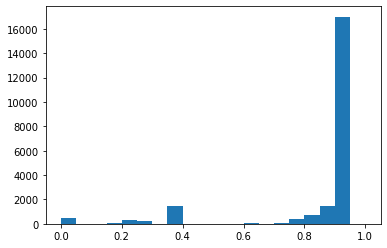

In [24]:
import matplotlib.pyplot as plt

train_proba = label_model.predict_proba(train_L)
plt.hist(train_proba[:, 0], bins=20, range=(0.0, 1.0))
plt.show()

## Part 4: Training our End Extraction Model

In this final section of the tutorial, we'll use the noisy training labels we generated in the last tutorial part to train our end machine learning model.

For this tutorial, we will be training a fairly effective deep learning model. More generally, however, Snorkel plugs in with many ML libraries, making it easy to use almost any state-of-the-art model as the end model!


## II. Training a _Long Short-term Memory_ (LSTM) Neural Network

[LSTMs](https://en.wikipedia.org/wiki/Long_short-term_memory) can acheive state-of-the-art performance on many text classification tasks. We'll train a simple LSTM model below. tf_model contains functions for processing features and building the tensorflow graphs for training and evaliation.

In [25]:
from tf_model import get_features_and_labels, get_model

model = get_model()
tokens, idx1, idx2, label_probs = get_features_and_labels(
    train_df, train_proba, tf.float32
)
batch_size = 64
num_epochs = 1
model.fit(
    (tokens, idx1, idx2),
    label_probs,
    batch_size=batch_size,
    steps_per_epoch=(len(train_df) // batch_size),
    epochs=num_epochs,
)

W0723 21:57:15.470609 140186113255232 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0723 21:57:15.575089 140186113255232 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0723 21:57:15.833739 140186113255232 deprecation.py:323] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:3794: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0723 21:57:15.870245 140186113255232 deprecation_wrapper.py:119] From /home/ubuntu/snorkel-tutorials/spouse/tf_model.py:46: The name tf.train.AdagradOptimizer is deprecated. Please use tf.compat.v1.train.AdagradOptimizer instead.



W0723 21:57:15.925025 140186113255232 deprecation.py:323] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:494: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


W0723 21:57:16.652180 140186113255232 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


  1/347 [..............................] - ETA: 4:08 - loss: 0.6871 - acc: 0.8438

  2/347 [..............................] - ETA: 2:32 - loss: 0.6582 - acc: 0.8672

  3/347 [..............................] - ETA: 1:59 - loss: 0.6376 - acc: 0.8698

  4/347 [..............................] - ETA: 1:44 - loss: 0.6149 - acc: 0.8828

  5/347 [..............................] - ETA: 1:35 - loss: 0.6060 - acc: 0.8719

  6/347 [..............................] - ETA: 1:39 - loss: 0.5974 - acc: 0.8620

  7/347 [..............................] - ETA: 1:42 - loss: 0.5909 - acc: 0.8549

  8/347 [..............................] - ETA: 1:43 - loss: 0.5845 - acc: 0.8496

  9/347 [..............................] - ETA: 1:45 - loss: 0.5747 - acc: 0.8542

 10/347 [..............................] - ETA: 1:42 - loss: 0.5645 - acc: 0.8594

 11/347 [..............................] - ETA: 1:40 - loss: 0.5571 - acc: 0.8622

 12/347 [>.............................] - ETA: 1:41 - loss: 0.5492 - acc: 0.8659

 13/347 [>.............................] - ETA: 1:36 - loss: 0.5402 - acc: 0.8726

 14/347 [>.............................] - ETA: 1:32 - loss: 0.5319 - acc: 0.8772

 15/347 [>.............................] - ETA: 1:31 - loss: 0.5286 - acc: 0.8771

 16/347 [>.............................] - ETA: 1:31 - loss: 0.5219 - acc: 0.8809

 17/347 [>.............................] - ETA: 1:31 - loss: 0.5132 - acc: 0.8869

 18/347 [>.............................] - ETA: 1:31 - loss: 0.5117 - acc: 0.8854

 19/347 [>.............................] - ETA: 1:31 - loss: 0.5125 - acc: 0.8832

 20/347 [>.............................] - ETA: 1:28 - loss: 0.5111 - acc: 0.8828

 21/347 [>.............................] - ETA: 1:31 - loss: 0.5097 - acc: 0.8832

 22/347 [>.............................] - ETA: 1:29 - loss: 0.5062 - acc: 0.8849

 23/347 [>.............................] - ETA: 1:31 - loss: 0.5025 - acc: 0.8872

 24/347 [=>............................] - ETA: 1:33 - loss: 0.4984 - acc: 0.8893

 25/347 [=>............................] - ETA: 1:35 - loss: 0.4962 - acc: 0.8900

 26/347 [=>............................] - ETA: 1:33 - loss: 0.4972 - acc: 0.8876

 27/347 [=>............................] - ETA: 1:32 - loss: 0.4928 - acc: 0.8912

 28/347 [=>............................] - ETA: 1:36 - loss: 0.4917 - acc: 0.8906

 29/347 [=>............................] - ETA: 1:39 - loss: 0.4891 - acc: 0.8917

 30/347 [=>............................] - ETA: 1:43 - loss: 0.4863 - acc: 0.8932

 31/347 [=>............................] - ETA: 1:46 - loss: 0.4870 - acc: 0.8916

 32/347 [=>............................] - ETA: 1:48 - loss: 0.4858 - acc: 0.8921

 33/347 [=>............................] - ETA: 1:48 - loss: 0.4879 - acc: 0.8892

 34/347 [=>............................] - ETA: 1:46 - loss: 0.4879 - acc: 0.8888

 35/347 [==>...........................] - ETA: 1:46 - loss: 0.4893 - acc: 0.8871

 36/347 [==>...........................] - ETA: 1:46 - loss: 0.4890 - acc: 0.8867

 37/347 [==>...........................] - ETA: 1:45 - loss: 0.4882 - acc: 0.8872

 38/347 [==>...........................] - ETA: 1:43 - loss: 0.4882 - acc: 0.8873

 39/347 [==>...........................] - ETA: 1:42 - loss: 0.4883 - acc: 0.8870

 40/347 [==>...........................] - ETA: 1:41 - loss: 0.4908 - acc: 0.8848

 41/347 [==>...........................] - ETA: 1:39 - loss: 0.4892 - acc: 0.8864

 42/347 [==>...........................] - ETA: 1:39 - loss: 0.4899 - acc: 0.8854

 43/347 [==>...........................] - ETA: 1:37 - loss: 0.4905 - acc: 0.8844

 44/347 [==>...........................] - ETA: 1:36 - loss: 0.4909 - acc: 0.8839

 45/347 [==>...........................] - ETA: 1:35 - loss: 0.4913 - acc: 0.8833

 46/347 [==>...........................] - ETA: 1:34 - loss: 0.4924 - acc: 0.8821

 47/347 [===>..........................] - ETA: 1:33 - loss: 0.4910 - acc: 0.8833

 48/347 [===>..........................] - ETA: 1:32 - loss: 0.4896 - acc: 0.8844

 49/347 [===>..........................] - ETA: 1:31 - loss: 0.4887 - acc: 0.8852

 50/347 [===>..........................] - ETA: 1:29 - loss: 0.4887 - acc: 0.8844

 51/347 [===>..........................] - ETA: 1:28 - loss: 0.4889 - acc: 0.8842

 52/347 [===>..........................] - ETA: 1:27 - loss: 0.4880 - acc: 0.8852

 53/347 [===>..........................] - ETA: 1:26 - loss: 0.4871 - acc: 0.8859

 54/347 [===>..........................] - ETA: 1:25 - loss: 0.4858 - acc: 0.8872

 55/347 [===>..........................] - ETA: 1:24 - loss: 0.4861 - acc: 0.8864

 56/347 [===>..........................] - ETA: 1:24 - loss: 0.4857 - acc: 0.8862

 57/347 [===>..........................] - ETA: 1:23 - loss: 0.4856 - acc: 0.8857

 58/347 [====>.........................] - ETA: 1:22 - loss: 0.4853 - acc: 0.8858

 59/347 [====>.........................] - ETA: 1:21 - loss: 0.4848 - acc: 0.8861

 60/347 [====>.........................] - ETA: 1:21 - loss: 0.4855 - acc: 0.8854

 61/347 [====>.........................] - ETA: 1:20 - loss: 0.4860 - acc: 0.8847

 62/347 [====>.........................] - ETA: 1:19 - loss: 0.4857 - acc: 0.8848

 63/347 [====>.........................] - ETA: 1:18 - loss: 0.4859 - acc: 0.8847

 64/347 [====>.........................] - ETA: 1:17 - loss: 0.4861 - acc: 0.8848

 65/347 [====>.........................] - ETA: 1:17 - loss: 0.4867 - acc: 0.8839

 66/347 [====>.........................] - ETA: 1:16 - loss: 0.4869 - acc: 0.8838

 67/347 [====>.........................] - ETA: 1:16 - loss: 0.4871 - acc: 0.8834

 68/347 [====>.........................] - ETA: 1:15 - loss: 0.4885 - acc: 0.8817

 69/347 [====>.........................] - ETA: 1:15 - loss: 0.4890 - acc: 0.8809

 70/347 [=====>........................] - ETA: 1:15 - loss: 0.4888 - acc: 0.8808

 71/347 [=====>........................] - ETA: 1:14 - loss: 0.4882 - acc: 0.8812

 72/347 [=====>........................] - ETA: 1:14 - loss: 0.4879 - acc: 0.8813

 73/347 [=====>........................] - ETA: 1:13 - loss: 0.4889 - acc: 0.8799

 74/347 [=====>........................] - ETA: 1:13 - loss: 0.4893 - acc: 0.8794

 75/347 [=====>........................] - ETA: 1:13 - loss: 0.4880 - acc: 0.8806

 76/347 [=====>........................] - ETA: 1:12 - loss: 0.4887 - acc: 0.8795

 77/347 [=====>........................] - ETA: 1:12 - loss: 0.4894 - acc: 0.8787

 78/347 [=====>........................] - ETA: 1:12 - loss: 0.4885 - acc: 0.8794

 79/347 [=====>........................] - ETA: 1:11 - loss: 0.4880 - acc: 0.8797

 80/347 [=====>........................] - ETA: 1:11 - loss: 0.4883 - acc: 0.8793

 81/347 [======>.......................] - ETA: 1:10 - loss: 0.4878 - acc: 0.8798

 82/347 [======>.......................] - ETA: 1:10 - loss: 0.4872 - acc: 0.8805

 83/347 [======>.......................] - ETA: 1:10 - loss: 0.4866 - acc: 0.8808

 84/347 [======>.......................] - ETA: 1:09 - loss: 0.4863 - acc: 0.8811

 85/347 [======>.......................] - ETA: 1:09 - loss: 0.4854 - acc: 0.8818

 86/347 [======>.......................] - ETA: 1:08 - loss: 0.4852 - acc: 0.8819

 87/347 [======>.......................] - ETA: 1:08 - loss: 0.4850 - acc: 0.8822

 88/347 [======>.......................] - ETA: 1:07 - loss: 0.4852 - acc: 0.8817

 89/347 [======>.......................] - ETA: 1:07 - loss: 0.4857 - acc: 0.8811

 90/347 [======>.......................] - ETA: 1:06 - loss: 0.4861 - acc: 0.8806

 91/347 [======>.......................] - ETA: 1:06 - loss: 0.4873 - acc: 0.8791

 92/347 [======>.......................] - ETA: 1:05 - loss: 0.4869 - acc: 0.8794

 93/347 [=======>......................] - ETA: 1:05 - loss: 0.4862 - acc: 0.8800

 94/347 [=======>......................] - ETA: 1:04 - loss: 0.4864 - acc: 0.8797

 95/347 [=======>......................] - ETA: 1:04 - loss: 0.4863 - acc: 0.8798

 96/347 [=======>......................] - ETA: 1:04 - loss: 0.4859 - acc: 0.8800

 97/347 [=======>......................] - ETA: 1:04 - loss: 0.4862 - acc: 0.8798

 98/347 [=======>......................] - ETA: 1:04 - loss: 0.4857 - acc: 0.8801

 99/347 [=======>......................] - ETA: 1:03 - loss: 0.4852 - acc: 0.8807

100/347 [=======>......................] - ETA: 1:03 - loss: 0.4846 - acc: 0.8813

101/347 [=======>......................] - ETA: 1:02 - loss: 0.4850 - acc: 0.8810

102/347 [=======>......................] - ETA: 1:02 - loss: 0.4843 - acc: 0.8814

103/347 [=======>......................] - ETA: 1:01 - loss: 0.4843 - acc: 0.8814

104/347 [=======>......................] - ETA: 1:01 - loss: 0.4838 - acc: 0.8818

105/347 [========>.....................] - ETA: 1:00 - loss: 0.4830 - acc: 0.8824

106/347 [========>.....................] - ETA: 1:00 - loss: 0.4830 - acc: 0.8824

107/347 [========>.....................] - ETA: 59s - loss: 0.4827 - acc: 0.8826 

108/347 [========>.....................] - ETA: 1:00 - loss: 0.4825 - acc: 0.8830

109/347 [========>.....................] - ETA: 1:00 - loss: 0.4818 - acc: 0.8836

110/347 [========>.....................] - ETA: 1:00 - loss: 0.4811 - acc: 0.8841

111/347 [========>.....................] - ETA: 1:00 - loss: 0.4813 - acc: 0.8837

112/347 [========>.....................] - ETA: 59s - loss: 0.4812 - acc: 0.8836 

113/347 [========>.....................] - ETA: 59s - loss: 0.4806 - acc: 0.8841

114/347 [========>.....................] - ETA: 58s - loss: 0.4805 - acc: 0.8842

115/347 [========>.....................] - ETA: 58s - loss: 0.4807 - acc: 0.8841

116/347 [=========>....................] - ETA: 58s - loss: 0.4807 - acc: 0.8840

117/347 [=========>....................] - ETA: 58s - loss: 0.4810 - acc: 0.8835

118/347 [=========>....................] - ETA: 58s - loss: 0.4811 - acc: 0.8833

119/347 [=========>....................] - ETA: 57s - loss: 0.4807 - acc: 0.8835

120/347 [=========>....................] - ETA: 57s - loss: 0.4803 - acc: 0.8841

121/347 [=========>....................] - ETA: 58s - loss: 0.4797 - acc: 0.8848

122/347 [=========>....................] - ETA: 57s - loss: 0.4793 - acc: 0.8851

123/347 [=========>....................] - ETA: 57s - loss: 0.4795 - acc: 0.8849

124/347 [=========>....................] - ETA: 57s - loss: 0.4793 - acc: 0.8848

125/347 [=========>....................] - ETA: 57s - loss: 0.4799 - acc: 0.8842

126/347 [=========>....................] - ETA: 57s - loss: 0.4794 - acc: 0.8847

127/347 [=========>....................] - ETA: 57s - loss: 0.4789 - acc: 0.8852

128/347 [==========>...................] - ETA: 56s - loss: 0.4791 - acc: 0.8849

129/347 [==========>...................] - ETA: 56s - loss: 0.4791 - acc: 0.8848

130/347 [==========>...................] - ETA: 56s - loss: 0.4789 - acc: 0.8849

131/347 [==========>...................] - ETA: 55s - loss: 0.4782 - acc: 0.8855

132/347 [==========>...................] - ETA: 55s - loss: 0.4780 - acc: 0.8858

133/347 [==========>...................] - ETA: 54s - loss: 0.4775 - acc: 0.8863

134/347 [==========>...................] - ETA: 54s - loss: 0.4768 - acc: 0.8869

135/347 [==========>...................] - ETA: 54s - loss: 0.4768 - acc: 0.8868

136/347 [==========>...................] - ETA: 53s - loss: 0.4767 - acc: 0.8869

137/347 [==========>...................] - ETA: 53s - loss: 0.4766 - acc: 0.8870

138/347 [==========>...................] - ETA: 53s - loss: 0.4767 - acc: 0.8869

139/347 [===========>..................] - ETA: 53s - loss: 0.4769 - acc: 0.8867

140/347 [===========>..................] - ETA: 53s - loss: 0.4766 - acc: 0.8869

141/347 [===========>..................] - ETA: 53s - loss: 0.4767 - acc: 0.8869

142/347 [===========>..................] - ETA: 53s - loss: 0.4769 - acc: 0.8868

143/347 [===========>..................] - ETA: 53s - loss: 0.4768 - acc: 0.8870

144/347 [===========>..................] - ETA: 52s - loss: 0.4769 - acc: 0.8868

145/347 [===========>..................] - ETA: 52s - loss: 0.4772 - acc: 0.8866

146/347 [===========>..................] - ETA: 52s - loss: 0.4775 - acc: 0.8862

147/347 [===========>..................] - ETA: 51s - loss: 0.4774 - acc: 0.8864

148/347 [===========>..................] - ETA: 51s - loss: 0.4772 - acc: 0.8866

149/347 [===========>..................] - ETA: 51s - loss: 0.4770 - acc: 0.8867

150/347 [===========>..................] - ETA: 51s - loss: 0.4774 - acc: 0.8864

151/347 [============>.................] - ETA: 51s - loss: 0.4770 - acc: 0.8867

152/347 [============>.................] - ETA: 50s - loss: 0.4770 - acc: 0.8866

153/347 [============>.................] - ETA: 50s - loss: 0.4772 - acc: 0.8865

154/347 [============>.................] - ETA: 50s - loss: 0.4778 - acc: 0.8860

155/347 [============>.................] - ETA: 49s - loss: 0.4776 - acc: 0.8861

156/347 [============>.................] - ETA: 49s - loss: 0.4773 - acc: 0.8863

157/347 [============>.................] - ETA: 49s - loss: 0.4775 - acc: 0.8859

158/347 [============>.................] - ETA: 48s - loss: 0.4772 - acc: 0.8862

159/347 [============>.................] - ETA: 48s - loss: 0.4773 - acc: 0.8860

160/347 [============>.................] - ETA: 48s - loss: 0.4776 - acc: 0.8855

161/347 [============>.................] - ETA: 47s - loss: 0.4782 - acc: 0.8851

162/347 [=============>................] - ETA: 48s - loss: 0.4777 - acc: 0.8856

163/347 [=============>................] - ETA: 47s - loss: 0.4777 - acc: 0.8856

164/347 [=============>................] - ETA: 47s - loss: 0.4774 - acc: 0.8859

165/347 [=============>................] - ETA: 46s - loss: 0.4772 - acc: 0.8861

166/347 [=============>................] - ETA: 46s - loss: 0.4770 - acc: 0.8862

167/347 [=============>................] - ETA: 46s - loss: 0.4771 - acc: 0.8860

168/347 [=============>................] - ETA: 45s - loss: 0.4766 - acc: 0.8865

169/347 [=============>................] - ETA: 45s - loss: 0.4764 - acc: 0.8867

170/347 [=============>................] - ETA: 45s - loss: 0.4761 - acc: 0.8869

171/347 [=============>................] - ETA: 45s - loss: 0.4760 - acc: 0.8869

172/347 [=============>................] - ETA: 44s - loss: 0.4754 - acc: 0.8874

173/347 [=============>................] - ETA: 44s - loss: 0.4750 - acc: 0.8878

174/347 [==============>...............] - ETA: 44s - loss: 0.4751 - acc: 0.8878

175/347 [==============>...............] - ETA: 43s - loss: 0.4754 - acc: 0.8876

176/347 [==============>...............] - ETA: 43s - loss: 0.4756 - acc: 0.8875

177/347 [==============>...............] - ETA: 43s - loss: 0.4755 - acc: 0.8875

178/347 [==============>...............] - ETA: 43s - loss: 0.4754 - acc: 0.8876

179/347 [==============>...............] - ETA: 43s - loss: 0.4756 - acc: 0.8875

180/347 [==============>...............] - ETA: 43s - loss: 0.4754 - acc: 0.8877

181/347 [==============>...............] - ETA: 43s - loss: 0.4752 - acc: 0.8879

182/347 [==============>...............] - ETA: 43s - loss: 0.4752 - acc: 0.8879

183/347 [==============>...............] - ETA: 42s - loss: 0.4751 - acc: 0.8878

184/347 [==============>...............] - ETA: 42s - loss: 0.4748 - acc: 0.8881

185/347 [==============>...............] - ETA: 42s - loss: 0.4746 - acc: 0.8883

186/347 [===============>..............] - ETA: 42s - loss: 0.4743 - acc: 0.8886

187/347 [===============>..............] - ETA: 41s - loss: 0.4745 - acc: 0.8885

188/347 [===============>..............] - ETA: 41s - loss: 0.4742 - acc: 0.8888

189/347 [===============>..............] - ETA: 41s - loss: 0.4744 - acc: 0.8886

190/347 [===============>..............] - ETA: 40s - loss: 0.4744 - acc: 0.8887

191/347 [===============>..............] - ETA: 40s - loss: 0.4740 - acc: 0.8890

192/347 [===============>..............] - ETA: 40s - loss: 0.4738 - acc: 0.8892

193/347 [===============>..............] - ETA: 39s - loss: 0.4734 - acc: 0.8895

194/347 [===============>..............] - ETA: 39s - loss: 0.4733 - acc: 0.8897

195/347 [===============>..............] - ETA: 39s - loss: 0.4731 - acc: 0.8898

196/347 [===============>..............] - ETA: 38s - loss: 0.4728 - acc: 0.8901

197/347 [================>.............] - ETA: 38s - loss: 0.4724 - acc: 0.8905

198/347 [================>.............] - ETA: 38s - loss: 0.4719 - acc: 0.8909

199/347 [================>.............] - ETA: 37s - loss: 0.4721 - acc: 0.8907

200/347 [================>.............] - ETA: 37s - loss: 0.4721 - acc: 0.8906

201/347 [================>.............] - ETA: 37s - loss: 0.4717 - acc: 0.8910

202/347 [================>.............] - ETA: 36s - loss: 0.4715 - acc: 0.8912

203/347 [================>.............] - ETA: 36s - loss: 0.4714 - acc: 0.8912

204/347 [================>.............] - ETA: 36s - loss: 0.4717 - acc: 0.8909

205/347 [================>.............] - ETA: 36s - loss: 0.4719 - acc: 0.8906

206/347 [================>.............] - ETA: 35s - loss: 0.4717 - acc: 0.8908

207/347 [================>.............] - ETA: 35s - loss: 0.4721 - acc: 0.8904

208/347 [================>.............] - ETA: 35s - loss: 0.4718 - acc: 0.8907

209/347 [=================>............] - ETA: 35s - loss: 0.4718 - acc: 0.8907

210/347 [=================>............] - ETA: 35s - loss: 0.4717 - acc: 0.8908

211/347 [=================>............] - ETA: 34s - loss: 0.4715 - acc: 0.8909

212/347 [=================>............] - ETA: 34s - loss: 0.4718 - acc: 0.8907

213/347 [=================>............] - ETA: 34s - loss: 0.4719 - acc: 0.8906

214/347 [=================>............] - ETA: 34s - loss: 0.4722 - acc: 0.8903

215/347 [=================>............] - ETA: 33s - loss: 0.4721 - acc: 0.8903

216/347 [=================>............] - ETA: 33s - loss: 0.4723 - acc: 0.8900

217/347 [=================>............] - ETA: 33s - loss: 0.4723 - acc: 0.8900

218/347 [=================>............] - ETA: 33s - loss: 0.4725 - acc: 0.8897

219/347 [=================>............] - ETA: 32s - loss: 0.4727 - acc: 0.8894

220/347 [==================>...........] - ETA: 32s - loss: 0.4725 - acc: 0.8896

221/347 [==================>...........] - ETA: 32s - loss: 0.4725 - acc: 0.8897

222/347 [==================>...........] - ETA: 31s - loss: 0.4725 - acc: 0.8896

223/347 [==================>...........] - ETA: 31s - loss: 0.4723 - acc: 0.8899

224/347 [==================>...........] - ETA: 31s - loss: 0.4727 - acc: 0.8894

225/347 [==================>...........] - ETA: 30s - loss: 0.4725 - acc: 0.8896

226/347 [==================>...........] - ETA: 30s - loss: 0.4721 - acc: 0.8899

227/347 [==================>...........] - ETA: 30s - loss: 0.4723 - acc: 0.8897

228/347 [==================>...........] - ETA: 30s - loss: 0.4723 - acc: 0.8897

229/347 [==================>...........] - ETA: 29s - loss: 0.4724 - acc: 0.8897

230/347 [==================>...........] - ETA: 29s - loss: 0.4728 - acc: 0.8893

231/347 [==================>...........] - ETA: 29s - loss: 0.4731 - acc: 0.8891

232/347 [===================>..........] - ETA: 29s - loss: 0.4731 - acc: 0.8890

233/347 [===================>..........] - ETA: 29s - loss: 0.4731 - acc: 0.8891

234/347 [===================>..........] - ETA: 29s - loss: 0.4731 - acc: 0.8891

235/347 [===================>..........] - ETA: 28s - loss: 0.4735 - acc: 0.8886

236/347 [===================>..........] - ETA: 28s - loss: 0.4736 - acc: 0.8886

237/347 [===================>..........] - ETA: 28s - loss: 0.4736 - acc: 0.8886

238/347 [===================>..........] - ETA: 28s - loss: 0.4734 - acc: 0.8889

239/347 [===================>..........] - ETA: 27s - loss: 0.4733 - acc: 0.8889

240/347 [===================>..........] - ETA: 27s - loss: 0.4735 - acc: 0.8887

241/347 [===================>..........] - ETA: 27s - loss: 0.4736 - acc: 0.8885

242/347 [===================>..........] - ETA: 27s - loss: 0.4739 - acc: 0.8882

243/347 [====================>.........] - ETA: 26s - loss: 0.4739 - acc: 0.8882

244/347 [====================>.........] - ETA: 26s - loss: 0.4737 - acc: 0.8884

245/347 [====================>.........] - ETA: 26s - loss: 0.4737 - acc: 0.8884

246/347 [====================>.........] - ETA: 25s - loss: 0.4739 - acc: 0.8883

247/347 [====================>.........] - ETA: 25s - loss: 0.4739 - acc: 0.8882

248/347 [====================>.........] - ETA: 25s - loss: 0.4737 - acc: 0.8884

249/347 [====================>.........] - ETA: 25s - loss: 0.4738 - acc: 0.8884

250/347 [====================>.........] - ETA: 24s - loss: 0.4740 - acc: 0.8882

251/347 [====================>.........] - ETA: 24s - loss: 0.4744 - acc: 0.8878

252/347 [====================>.........] - ETA: 24s - loss: 0.4749 - acc: 0.8871

253/347 [====================>.........] - ETA: 23s - loss: 0.4751 - acc: 0.8869

254/347 [====================>.........] - ETA: 23s - loss: 0.4751 - acc: 0.8867

255/347 [=====================>........] - ETA: 23s - loss: 0.4753 - acc: 0.8865

256/347 [=====================>........] - ETA: 23s - loss: 0.4752 - acc: 0.8865

257/347 [=====================>........] - ETA: 22s - loss: 0.4752 - acc: 0.8865

258/347 [=====================>........] - ETA: 22s - loss: 0.4752 - acc: 0.8865

259/347 [=====================>........] - ETA: 22s - loss: 0.4753 - acc: 0.8863

260/347 [=====================>........] - ETA: 22s - loss: 0.4753 - acc: 0.8863

261/347 [=====================>........] - ETA: 21s - loss: 0.4753 - acc: 0.8863

262/347 [=====================>........] - ETA: 21s - loss: 0.4754 - acc: 0.8862

263/347 [=====================>........] - ETA: 21s - loss: 0.4754 - acc: 0.8861

264/347 [=====================>........] - ETA: 21s - loss: 0.4756 - acc: 0.8859

265/347 [=====================>........] - ETA: 20s - loss: 0.4756 - acc: 0.8859

266/347 [=====================>........] - ETA: 20s - loss: 0.4757 - acc: 0.8858

267/347 [======================>.......] - ETA: 20s - loss: 0.4757 - acc: 0.8857

268/347 [======================>.......] - ETA: 20s - loss: 0.4758 - acc: 0.8857

269/347 [======================>.......] - ETA: 19s - loss: 0.4757 - acc: 0.8857

270/347 [======================>.......] - ETA: 19s - loss: 0.4757 - acc: 0.8857

271/347 [======================>.......] - ETA: 19s - loss: 0.4755 - acc: 0.8859

272/347 [======================>.......] - ETA: 19s - loss: 0.4755 - acc: 0.8860

273/347 [======================>.......] - ETA: 18s - loss: 0.4755 - acc: 0.8860

274/347 [======================>.......] - ETA: 18s - loss: 0.4755 - acc: 0.8859

275/347 [======================>.......] - ETA: 18s - loss: 0.4753 - acc: 0.8860

276/347 [======================>.......] - ETA: 17s - loss: 0.4752 - acc: 0.8861

277/347 [======================>.......] - ETA: 17s - loss: 0.4754 - acc: 0.8859

278/347 [=======================>......] - ETA: 17s - loss: 0.4752 - acc: 0.8861

279/347 [=======================>......] - ETA: 17s - loss: 0.4753 - acc: 0.8860

280/347 [=======================>......] - ETA: 16s - loss: 0.4752 - acc: 0.8860

281/347 [=======================>......] - ETA: 16s - loss: 0.4755 - acc: 0.8857

282/347 [=======================>......] - ETA: 16s - loss: 0.4756 - acc: 0.8856

283/347 [=======================>......] - ETA: 16s - loss: 0.4758 - acc: 0.8853

284/347 [=======================>......] - ETA: 15s - loss: 0.4760 - acc: 0.8852

285/347 [=======================>......] - ETA: 15s - loss: 0.4761 - acc: 0.8851

286/347 [=======================>......] - ETA: 15s - loss: 0.4763 - acc: 0.8849

287/347 [=======================>......] - ETA: 14s - loss: 0.4763 - acc: 0.8850

288/347 [=======================>......] - ETA: 14s - loss: 0.4763 - acc: 0.8851

289/347 [=======================>......] - ETA: 14s - loss: 0.4760 - acc: 0.8853

290/347 [========================>.....] - ETA: 14s - loss: 0.4762 - acc: 0.8851

291/347 [========================>.....] - ETA: 13s - loss: 0.4762 - acc: 0.8850

292/347 [========================>.....] - ETA: 13s - loss: 0.4763 - acc: 0.8850

293/347 [========================>.....] - ETA: 13s - loss: 0.4761 - acc: 0.8851

294/347 [========================>.....] - ETA: 13s - loss: 0.4762 - acc: 0.8850

295/347 [========================>.....] - ETA: 12s - loss: 0.4763 - acc: 0.8849

296/347 [========================>.....] - ETA: 12s - loss: 0.4760 - acc: 0.8851

297/347 [========================>.....] - ETA: 12s - loss: 0.4758 - acc: 0.8854

298/347 [========================>.....] - ETA: 12s - loss: 0.4758 - acc: 0.8854

299/347 [========================>.....] - ETA: 11s - loss: 0.4757 - acc: 0.8856

300/347 [========================>.....] - ETA: 11s - loss: 0.4756 - acc: 0.8857

301/347 [=========================>....] - ETA: 11s - loss: 0.4758 - acc: 0.8854

302/347 [=========================>....] - ETA: 11s - loss: 0.4757 - acc: 0.8855

303/347 [=========================>....] - ETA: 10s - loss: 0.4756 - acc: 0.8856

304/347 [=========================>....] - ETA: 10s - loss: 0.4756 - acc: 0.8855

305/347 [=========================>....] - ETA: 10s - loss: 0.4754 - acc: 0.8857

306/347 [=========================>....] - ETA: 10s - loss: 0.4755 - acc: 0.8856

307/347 [=========================>....] - ETA: 9s - loss: 0.4752 - acc: 0.8859 

308/347 [=========================>....] - ETA: 9s - loss: 0.4755 - acc: 0.8857

309/347 [=========================>....] - ETA: 9s - loss: 0.4754 - acc: 0.8857

310/347 [=========================>....] - ETA: 9s - loss: 0.4753 - acc: 0.8858

311/347 [=========================>....] - ETA: 8s - loss: 0.4752 - acc: 0.8859

312/347 [=========================>....] - ETA: 8s - loss: 0.4751 - acc: 0.8860

313/347 [==========================>...] - ETA: 8s - loss: 0.4752 - acc: 0.8859

314/347 [==========================>...] - ETA: 8s - loss: 0.4754 - acc: 0.8857

315/347 [==========================>...] - ETA: 7s - loss: 0.4757 - acc: 0.8854

316/347 [==========================>...] - ETA: 7s - loss: 0.4756 - acc: 0.8855

317/347 [==========================>...] - ETA: 7s - loss: 0.4756 - acc: 0.8854

318/347 [==========================>...] - ETA: 7s - loss: 0.4756 - acc: 0.8854

319/347 [==========================>...] - ETA: 6s - loss: 0.4756 - acc: 0.8854

320/347 [==========================>...] - ETA: 6s - loss: 0.4755 - acc: 0.8855

321/347 [==========================>...] - ETA: 6s - loss: 0.4757 - acc: 0.8854

322/347 [==========================>...] - ETA: 6s - loss: 0.4756 - acc: 0.8855

323/347 [==========================>...] - ETA: 5s - loss: 0.4756 - acc: 0.8854

324/347 [===========================>..] - ETA: 5s - loss: 0.4757 - acc: 0.8854

325/347 [===========================>..] - ETA: 5s - loss: 0.4758 - acc: 0.8852

326/347 [===========================>..] - ETA: 5s - loss: 0.4761 - acc: 0.8850

327/347 [===========================>..] - ETA: 4s - loss: 0.4760 - acc: 0.8850

328/347 [===========================>..] - ETA: 4s - loss: 0.4762 - acc: 0.8848

329/347 [===========================>..] - ETA: 4s - loss: 0.4764 - acc: 0.8846

330/347 [===========================>..] - ETA: 4s - loss: 0.4764 - acc: 0.8847

331/347 [===========================>..] - ETA: 3s - loss: 0.4764 - acc: 0.8846

332/347 [===========================>..] - ETA: 3s - loss: 0.4766 - acc: 0.8844

333/347 [===========================>..] - ETA: 3s - loss: 0.4767 - acc: 0.8842

334/347 [===========================>..] - ETA: 3s - loss: 0.4770 - acc: 0.8840

335/347 [===========================>..] - ETA: 2s - loss: 0.4767 - acc: 0.8843

336/347 [============================>.] - ETA: 2s - loss: 0.4768 - acc: 0.8842

337/347 [============================>.] - ETA: 2s - loss: 0.4766 - acc: 0.8844

338/347 [============================>.] - ETA: 2s - loss: 0.4765 - acc: 0.8846

339/347 [============================>.] - ETA: 1s - loss: 0.4765 - acc: 0.8845

340/347 [============================>.] - ETA: 1s - loss: 0.4764 - acc: 0.8846

341/347 [============================>.] - ETA: 1s - loss: 0.4764 - acc: 0.8845

342/347 [============================>.] - ETA: 1s - loss: 0.4766 - acc: 0.8843

343/347 [============================>.] - ETA: 0s - loss: 0.4767 - acc: 0.8842

344/347 [============================>.] - ETA: 0s - loss: 0.4766 - acc: 0.8842

345/347 [============================>.] - ETA: 0s - loss: 0.4767 - acc: 0.8841

346/347 [============================>.] - ETA: 0s - loss: 0.4767 - acc: 0.8841

347/347 [==============================] - 85s 244ms/step - loss: 0.4767 - acc: 0.8841


Measure the trained model's prediction accuracy.

In [26]:
# Truncate sentences to limit memory usage when padding.
def get_feature_arrays(df):
    def pad_or_truncate(l, max_length=25):
        return l[:max_length] + [""] * (max_length - len(l))

    tokens = np.array(list(map(pad_or_truncate, df.tokens)))
    idx1 = np.array(list(map(list, df.person1_word_idx)))
    idx2 = np.array(list(map(list, df.person2_word_idx)))
    return tokens, idx1, idx2


test_tokens, test_idx1, test_idx2 = get_feature_arrays(test_df)
probs = model.predict((test_tokens, test_idx1, test_idx2))
preds = probs_to_preds(probs)
print(
    f"Test Accuracy when trained with soft labels: {metric_score(test_labels, preds=preds, metric='accuracy')}"
)
print(
    f"Test ROC-AUC when trained with soft labels: {metric_score(test_labels, probs=probs, metric='roc_auc')}"
)

Test Accuracy when trained with soft labels: 0.9192891521658645
Test ROC-AUC when trained with soft labels: 0.4611338754909532


We compare this to an equivalent model that is only trained using the dev set labels. The accuracy is similar in other cases, because the dataset is very unbalanced. However, the ROC-AUC is lower when just training on the dev set, due to the much smaller number of examples.

In [27]:
from snorkel.analysis.utils import preds_to_probs

dev_label_probs = preds_to_probs(dev_labels, 2)

dev_model = get_model()
dev_tokens, dev_idx1, dev_idx2 = get_feature_arrays(dev_df)
num_epochs = 10  # Change to 10.
dev_model.fit(
    (dev_tokens, dev_idx1, dev_idx2),
    dev_label_probs,
    batch_size=batch_size,
    epochs=num_epochs,
)

dev_probs = dev_model.predict((test_tokens, test_idx1, test_idx2))
dev_preds = probs_to_preds(dev_probs)
print(
    f"Test Accuracy when trained with dev labels: {metric_score(test_labels, preds=dev_preds, metric='accuracy')}"
)
print(
    f"Test ROC-AUC when trained with dev labels: {metric_score(test_labels, probs=dev_probs, metric='roc_auc')}"
)

Epoch 1/10


  64/2811 [..............................] - ETA: 19s - loss: 0.6977 - acc: 0.2188

 192/2811 [=>............................] - ETA: 7s - loss: 0.6092 - acc: 0.6875 

 320/2811 [==>...........................] - ETA: 4s - loss: 0.5396 - acc: 0.7906

 448/2811 [===>..........................] - ETA: 3s - loss: 0.4786 - acc: 0.8393

 576/2811 [=====>........................] - ETA: 2s - loss: 0.4506 - acc: 0.8524

 704/2811 [======>.......................] - ETA: 2s - loss: 0.4091 - acc: 0.8722

 832/2811 [=======>......................] - ETA: 2s - loss: 0.3861 - acc: 0.8810

 960/2811 [=========>....................] - ETA: 1s - loss: 0.3663 - acc: 0.8885

1088/2811 [==========>...................] - ETA: 1s - loss: 0.3434 - acc: 0.8971

1216/2811 [===========>..................] - ETA: 1s - loss: 0.3433 - acc: 0.8972

1344/2811 [=============>................] - ETA: 1s - loss: 0.3354 - acc: 0.9003

1472/2811 [==============>...............] - ETA: 1s - loss: 0.3285 - acc: 0.9029

1600/2811 [================>.............] - ETA: 0s - loss: 0.3142 - acc: 0.9081

1728/2811 [=================>............] - ETA: 0s - loss: 0.3134 - acc: 0.9086

1856/2811 [==================>...........] - ETA: 0s - loss: 0.3094 - acc: 0.9100

1984/2811 [====================>.........] - ETA: 0s - loss: 0.3035 - acc: 0.9123

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2982 - acc: 0.9143

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2980 - acc: 0.9143

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2967 - acc: 0.9147

2496/2811 [=========================>....] - ETA: 0s - loss: 0.3004 - acc: 0.9131

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2983 - acc: 0.9139

2752/2811 [============================>.] - ETA: 0s - loss: 0.2972 - acc: 0.9142

2811/2811 [==============================] - 2s 645us/sample - loss: 0.2945 - acc: 0.9153


Epoch 2/10
  64/2811 [..............................] - ETA: 1s - loss: 0.1483 - acc: 0.9688

 192/2811 [=>............................] - ETA: 1s - loss: 0.1457 - acc: 0.9688

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2008 - acc: 0.9500

 448/2811 [===>..........................] - ETA: 1s - loss: 0.1928 - acc: 0.9531

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2024 - acc: 0.9497

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2326 - acc: 0.9389

 832/2811 [=======>......................] - ETA: 0s - loss: 0.2391 - acc: 0.9363

 960/2811 [=========>....................] - ETA: 0s - loss: 0.2365 - acc: 0.9375

1088/2811 [==========>...................] - ETA: 0s - loss: 0.2339 - acc: 0.9384

1216/2811 [===========>..................] - ETA: 0s - loss: 0.2294 - acc: 0.9400

1344/2811 [=============>................] - ETA: 0s - loss: 0.2346 - acc: 0.9382

1472/2811 [==============>...............] - ETA: 0s - loss: 0.2364 - acc: 0.9375

1600/2811 [================>.............] - ETA: 0s - loss: 0.2396 - acc: 0.9362

1728/2811 [=================>............] - ETA: 0s - loss: 0.2376 - acc: 0.9369

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2430 - acc: 0.9348

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2450 - acc: 0.9340

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2431 - acc: 0.9347

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2377 - acc: 0.9366

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2390 - acc: 0.9362

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2429 - acc: 0.9347

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2453 - acc: 0.9337

2752/2811 [============================>.] - ETA: 0s - loss: 0.2492 - acc: 0.9320

2811/2811 [==============================] - 1s 494us/sample - loss: 0.2484 - acc: 0.9324


Epoch 3/10
  64/2811 [..............................] - ETA: 1s - loss: 0.2701 - acc: 0.9219

 192/2811 [=>............................] - ETA: 1s - loss: 0.2078 - acc: 0.9479

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2095 - acc: 0.9469

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2284 - acc: 0.9397

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2298 - acc: 0.9392

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2191 - acc: 0.9432

 832/2811 [=======>......................] - ETA: 0s - loss: 0.2281 - acc: 0.9399

 960/2811 [=========>....................] - ETA: 0s - loss: 0.2316 - acc: 0.9385

1088/2811 [==========>...................] - ETA: 0s - loss: 0.2434 - acc: 0.9338

1216/2811 [===========>..................] - ETA: 0s - loss: 0.2443 - acc: 0.9334

1344/2811 [=============>................] - ETA: 0s - loss: 0.2452 - acc: 0.9330

1472/2811 [==============>...............] - ETA: 0s - loss: 0.2463 - acc: 0.9327

1600/2811 [================>.............] - ETA: 0s - loss: 0.2455 - acc: 0.9331

1728/2811 [=================>............] - ETA: 0s - loss: 0.2430 - acc: 0.9340

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2438 - acc: 0.9337

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2448 - acc: 0.9335

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2490 - acc: 0.9318

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2492 - acc: 0.9317

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2462 - acc: 0.9329

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2501 - acc: 0.9315

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2486 - acc: 0.9322

2752/2811 [============================>.] - ETA: 0s - loss: 0.2487 - acc: 0.9320

2811/2811 [==============================] - 1s 491us/sample - loss: 0.2477 - acc: 0.9324


Epoch 4/10
  64/2811 [..............................] - ETA: 1s - loss: 0.1916 - acc: 0.9531

 192/2811 [=>............................] - ETA: 1s - loss: 0.2978 - acc: 0.9167

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2878 - acc: 0.9187

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2664 - acc: 0.9263

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2775 - acc: 0.9219

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2628 - acc: 0.9276

 832/2811 [=======>......................] - ETA: 0s - loss: 0.2488 - acc: 0.9327

 960/2811 [=========>....................] - ETA: 0s - loss: 0.2500 - acc: 0.9323

1088/2811 [==========>...................] - ETA: 0s - loss: 0.2407 - acc: 0.9357

1216/2811 [===========>..................] - ETA: 0s - loss: 0.2446 - acc: 0.9342

1344/2811 [=============>................] - ETA: 0s - loss: 0.2374 - acc: 0.9368

1472/2811 [==============>...............] - ETA: 0s - loss: 0.2481 - acc: 0.9327

1600/2811 [================>.............] - ETA: 0s - loss: 0.2455 - acc: 0.9337

1728/2811 [=================>............] - ETA: 0s - loss: 0.2535 - acc: 0.9306

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2559 - acc: 0.9294

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2570 - acc: 0.9289

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2532 - acc: 0.9304

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2531 - acc: 0.9304

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2543 - acc: 0.9299

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2511 - acc: 0.9311

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2491 - acc: 0.9318

2752/2811 [============================>.] - ETA: 0s - loss: 0.2464 - acc: 0.9328

2811/2811 [==============================] - 1s 492us/sample - loss: 0.2475 - acc: 0.9324


Epoch 5/10
  64/2811 [..............................] - ETA: 1s - loss: 0.1464 - acc: 0.9688

 192/2811 [=>............................] - ETA: 1s - loss: 0.2332 - acc: 0.9375

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2165 - acc: 0.9438

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2026 - acc: 0.9487

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2091 - acc: 0.9462

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2052 - acc: 0.9474

 832/2811 [=======>......................] - ETA: 0s - loss: 0.2268 - acc: 0.9399

 960/2811 [=========>....................] - ETA: 0s - loss: 0.2407 - acc: 0.9344

1088/2811 [==========>...................] - ETA: 0s - loss: 0.2462 - acc: 0.9320

1216/2811 [===========>..................] - ETA: 0s - loss: 0.2428 - acc: 0.9334

1344/2811 [=============>................] - ETA: 0s - loss: 0.2435 - acc: 0.9330

1472/2811 [==============>...............] - ETA: 0s - loss: 0.2443 - acc: 0.9327

1600/2811 [================>.............] - ETA: 0s - loss: 0.2451 - acc: 0.9325

1728/2811 [=================>............] - ETA: 0s - loss: 0.2397 - acc: 0.9346

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2392 - acc: 0.9348

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2455 - acc: 0.9325

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2424 - acc: 0.9337

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2431 - acc: 0.9335

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2426 - acc: 0.9337

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2431 - acc: 0.9335

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2426 - acc: 0.9337

2752/2811 [============================>.] - ETA: 0s - loss: 0.2421 - acc: 0.9339

2811/2811 [==============================] - 1s 491us/sample - loss: 0.2458 - acc: 0.9324


Epoch 6/10
  64/2811 [..............................] - ETA: 1s - loss: 0.2343 - acc: 0.9375

 192/2811 [=>............................] - ETA: 1s - loss: 0.3086 - acc: 0.9062

 320/2811 [==>...........................] - ETA: 1s - loss: 0.3009 - acc: 0.9094

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2765 - acc: 0.9196

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2841 - acc: 0.9167

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2682 - acc: 0.9233

 832/2811 [=======>......................] - ETA: 0s - loss: 0.2592 - acc: 0.9267

 960/2811 [=========>....................] - ETA: 0s - loss: 0.2584 - acc: 0.9271

1088/2811 [==========>...................] - ETA: 0s - loss: 0.2525 - acc: 0.9292

1216/2811 [===========>..................] - ETA: 0s - loss: 0.2458 - acc: 0.9317

1344/2811 [=============>................] - ETA: 0s - loss: 0.2466 - acc: 0.9315

1472/2811 [==============>...............] - ETA: 0s - loss: 0.2452 - acc: 0.9321

1600/2811 [================>.............] - ETA: 0s - loss: 0.2409 - acc: 0.9337

1728/2811 [=================>............] - ETA: 0s - loss: 0.2432 - acc: 0.9329

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2382 - acc: 0.9348

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2404 - acc: 0.9340

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2386 - acc: 0.9347

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2452 - acc: 0.9321

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2466 - acc: 0.9316

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2469 - acc: 0.9315

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2481 - acc: 0.9310

2752/2811 [============================>.] - ETA: 0s - loss: 0.2456 - acc: 0.9320

2811/2811 [==============================] - 1s 488us/sample - loss: 0.2446 - acc: 0.9324


Epoch 7/10
  64/2811 [..............................] - ETA: 1s - loss: 0.3983 - acc: 0.8750

 192/2811 [=>............................] - ETA: 1s - loss: 0.2627 - acc: 0.9271

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2163 - acc: 0.9438

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2284 - acc: 0.9397

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2339 - acc: 0.9375

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2335 - acc: 0.9375

 832/2811 [=======>......................] - ETA: 0s - loss: 0.2233 - acc: 0.9411

 960/2811 [=========>....................] - ETA: 0s - loss: 0.2271 - acc: 0.9396

1088/2811 [==========>...................] - ETA: 0s - loss: 0.2323 - acc: 0.9375

1216/2811 [===========>..................] - ETA: 0s - loss: 0.2300 - acc: 0.9383

1344/2811 [=============>................] - ETA: 0s - loss: 0.2281 - acc: 0.9390

1472/2811 [==============>...............] - ETA: 0s - loss: 0.2337 - acc: 0.9368

1600/2811 [================>.............] - ETA: 0s - loss: 0.2382 - acc: 0.9350

1728/2811 [=================>............] - ETA: 0s - loss: 0.2462 - acc: 0.9317

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2500 - acc: 0.9300

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2453 - acc: 0.9320

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2443 - acc: 0.9323

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2458 - acc: 0.9317

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2472 - acc: 0.9312

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2422 - acc: 0.9331

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2435 - acc: 0.9325

2752/2811 [============================>.] - ETA: 0s - loss: 0.2419 - acc: 0.9331

2811/2811 [==============================] - 1s 495us/sample - loss: 0.2439 - acc: 0.9324


Epoch 8/10
  64/2811 [..............................] - ETA: 1s - loss: 0.3113 - acc: 0.9062

 192/2811 [=>............................] - ETA: 1s - loss: 0.2463 - acc: 0.9323

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2066 - acc: 0.9469

 448/2811 [===>..........................] - ETA: 1s - loss: 0.1874 - acc: 0.9531

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2078 - acc: 0.9462

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2274 - acc: 0.9389

 832/2811 [=======>......................] - ETA: 0s - loss: 0.2253 - acc: 0.9399

 960/2811 [=========>....................] - ETA: 0s - loss: 0.2283 - acc: 0.9385

1088/2811 [==========>...................] - ETA: 0s - loss: 0.2162 - acc: 0.9430

1216/2811 [===========>..................] - ETA: 0s - loss: 0.2242 - acc: 0.9400

1344/2811 [=============>................] - ETA: 0s - loss: 0.2362 - acc: 0.9353

1472/2811 [==============>...............] - ETA: 0s - loss: 0.2449 - acc: 0.9314

1600/2811 [================>.............] - ETA: 0s - loss: 0.2457 - acc: 0.9312

1728/2811 [=================>............] - ETA: 0s - loss: 0.2420 - acc: 0.9329

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2464 - acc: 0.9310

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2431 - acc: 0.9325

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2446 - acc: 0.9318

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2438 - acc: 0.9321

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2387 - acc: 0.9341

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2401 - acc: 0.9335

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2396 - acc: 0.9337

2752/2811 [============================>.] - ETA: 0s - loss: 0.2416 - acc: 0.9328

2811/2811 [==============================] - 1s 489us/sample - loss: 0.2425 - acc: 0.9324


Epoch 9/10
  64/2811 [..............................] - ETA: 1s - loss: 0.2291 - acc: 0.9375

 192/2811 [=>............................] - ETA: 1s - loss: 0.1883 - acc: 0.9531

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2628 - acc: 0.9250

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2694 - acc: 0.9219

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2649 - acc: 0.9236

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2621 - acc: 0.9247

 832/2811 [=======>......................] - ETA: 0s - loss: 0.2479 - acc: 0.9303

 960/2811 [=========>....................] - ETA: 0s - loss: 0.2367 - acc: 0.9344

1088/2811 [==========>...................] - ETA: 0s - loss: 0.2250 - acc: 0.9384

1216/2811 [===========>..................] - ETA: 0s - loss: 0.2319 - acc: 0.9367

1344/2811 [=============>................] - ETA: 0s - loss: 0.2320 - acc: 0.9368

1472/2811 [==============>...............] - ETA: 0s - loss: 0.2300 - acc: 0.9375

1600/2811 [================>.............] - ETA: 0s - loss: 0.2317 - acc: 0.9369

1728/2811 [=================>............] - ETA: 0s - loss: 0.2266 - acc: 0.9387

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2295 - acc: 0.9375

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2374 - acc: 0.9345

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2347 - acc: 0.9356

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2343 - acc: 0.9357

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2337 - acc: 0.9358

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2362 - acc: 0.9347

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2337 - acc: 0.9356

2752/2811 [============================>.] - ETA: 0s - loss: 0.2383 - acc: 0.9339

2811/2811 [==============================] - 1s 489us/sample - loss: 0.2417 - acc: 0.9324


Epoch 10/10
  64/2811 [..............................] - ETA: 1s - loss: 0.2717 - acc: 0.9219

 192/2811 [=>............................] - ETA: 1s - loss: 0.2092 - acc: 0.9479

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2508 - acc: 0.9312

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2636 - acc: 0.9241

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2470 - acc: 0.9306

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2360 - acc: 0.9347

 832/2811 [=======>......................] - ETA: 0s - loss: 0.2497 - acc: 0.9291

 960/2811 [=========>....................] - ETA: 0s - loss: 0.2448 - acc: 0.9312

1088/2811 [==========>...................] - ETA: 0s - loss: 0.2480 - acc: 0.9301

1216/2811 [===========>..................] - ETA: 0s - loss: 0.2462 - acc: 0.9309

1344/2811 [=============>................] - ETA: 0s - loss: 0.2441 - acc: 0.9315

1472/2811 [==============>...............] - ETA: 0s - loss: 0.2426 - acc: 0.9321

1600/2811 [================>.............] - ETA: 0s - loss: 0.2460 - acc: 0.9306

1728/2811 [=================>............] - ETA: 0s - loss: 0.2453 - acc: 0.9306

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2442 - acc: 0.9310

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2441 - acc: 0.9309

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2380 - acc: 0.9332

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2378 - acc: 0.9335

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2374 - acc: 0.9337

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2402 - acc: 0.9327

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2393 - acc: 0.9329

2752/2811 [============================>.] - ETA: 0s - loss: 0.2431 - acc: 0.9313

2811/2811 [==============================] - 1s 490us/sample - loss: 0.2406 - acc: 0.9324


Test Accuracy when trained with dev labels: 0.9192891521658645
Test ROC-AUC when trained with dev labels: 0.38499687785196224
